# Time-Series Research Project

- Researched by Shane Stoll
- Advised by Uzma Mushtaque

# Libraries to import

In [1]:
from datetime import datetime
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import keras
import yfinance as yf
import csv, os
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.preprocessing import MinMaxScaler
from pandas_datareader.data import DataReader
from pandas_datareader import data as pdr
import pandas_ta as ta
from projectpro import model_snapshot, checkpoint
from keras.layers import LSTM, SimpleRNN, Dense, Dropout, Bidirectional, GRU
from keras.models import Sequential
from keras.optimizers import Adam, RMSprop, Nadam, Adagrad, Adadelta, SGD
from keras.callbacks import EarlyStopping
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [2]:
keras.backend.set_image_data_format("channels_last")
sns.set_style('whitegrid')
plt.style.use("fivethirtyeight")
#yf.pdr_override()
%matplotlib inline

In [3]:
# Fetch NVIDIA data (Scaled using Min-Max Scaler with relevant columns (Open, High, Low, Close, Adjusted Close, and Volume) normalized to values between 0 and 1)
#dataset = yf.download('NVDA', start='2010-01-01', end='2024-08-28')

# Load the dataset
dataset = pd.read_csv("nvidia_stock_data.csv", index_col="Date", parse_dates=True)

# Display the first few rows
print(dataset.head())

# Save the data to a CSV file
#dataset.to_csv('nvidia_stock_data.csv')    

               Open    High      Low    Close  Adj Close     Volume
Date                                                               
2010-01-04  0.46275  0.4655  0.45275  0.46225   0.423923  800204000
2010-01-05  0.46050  0.4740  0.46050  0.46900   0.430113  728648000
2010-01-06  0.46875  0.4730  0.46425  0.47200   0.432864  649168000
2010-01-07  0.46950  0.4715  0.45925  0.46275   0.424381  547792000
2010-01-08  0.45900  0.4670  0.45625  0.46375   0.425298  478168000


In [4]:
def train_test_plot(dataset, tstart, tend, title):
    dataset.loc[f"{tstart}":f"{tend}", "High"].plot(figsize=(16, 4), legend=True)
    dataset.loc[f"{tend+1}":, "High"].plot(figsize=(16, 4), legend=True)
    plt.legend([f"Train (Before {tend+1})", f"Test ({tend+1} and beyond)"])
    plt.title(title)
    plt.show()

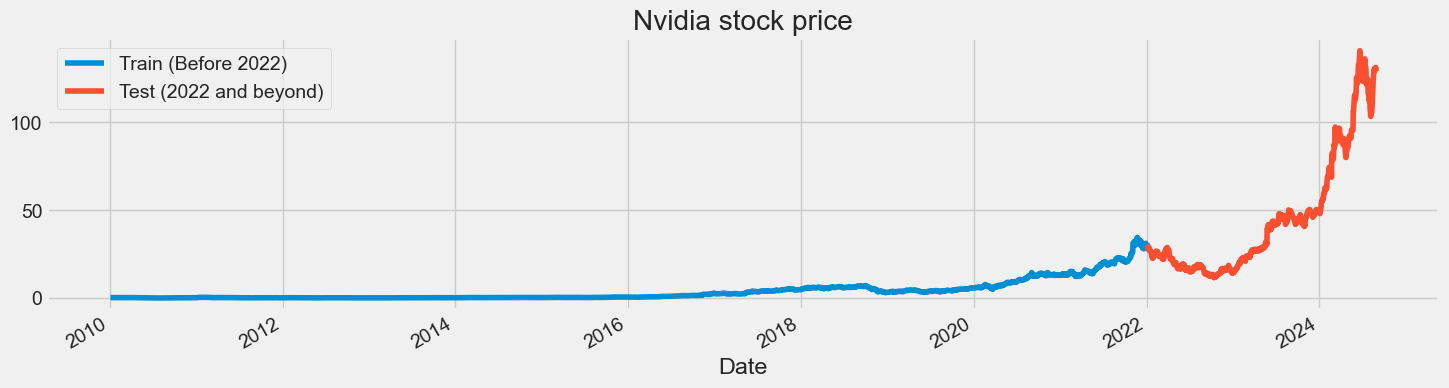

In [5]:
tstart = 2010
tend = 2021

train_test_plot(dataset, tstart, tend, "Nvidia stock price")

# Create train and test datasets

In [6]:
# Check the column names in the dataset to ensure 'Date' is present
print(dataset.columns)

# Reload the dataset, ensuring the 'Date' column is there
dataset = pd.read_csv('nvidia_stock_data.csv')

# Convert 'Date' to datetime if necessary
dataset['Date'] = pd.to_datetime(dataset['Date'])

# Set 'Date' as the index
dataset.set_index('Date', inplace=True)

# Verify the columns after processing
print(dataset.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [7]:
# Adjust the train_test_split function to use proper date strings and index
def train_test_split(dataset, train_start, train_end, columns=['High']):
    train = dataset.loc[train_start:train_end, columns].values
    test = dataset.loc[train_end:, columns].values
    return train, test

# Set correct date ranges for training and testing
train_start = '2010-01-01'
train_end = '2021-12-31'

# Split the data
training_set, test_set = train_test_split(dataset, train_start, train_end)

# Check the sizes of the training and test sets
print(f"Training set size: {len(training_set)}")
print(f"Test set size: {len(test_set)}")

Training set size: 3021
Test set size: 667


# Scaling dataset values

In [8]:
# sc = MinMaxScaler(feature_range=(0, 1))
# training_set = training_set.reshape(-1, 1)
# training_set_scaled = sc.fit_transform(training_set)

# Initialize the MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))

# Scale the training data
training_set_scaled = sc.fit_transform(training_set)

# Scale the test data
test_set_scaled = sc.transform(test_set)

# Creating overlapping window batches

In [9]:
n_steps = 60
features = 1

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

def create_dataset(dataset, n_steps):
    # Reshape into X=t and Y=t+1
    # Split the training and test data into sequences
    X, y = split_sequence(dataset, n_steps)
    # Reshape the input data to 3D (samples, time steps, features)
    X = X.reshape((X.shape[0], X.shape[1], features))
    return X, y

In [10]:
# Reshape the input data to 3D (samples, time steps, features)
X_train, y_train = create_dataset(training_set_scaled, n_steps)
X_test, y_test = create_dataset(test_set_scaled, n_steps)

# Evaluation

In [11]:
def plot_predictions(test, predicted, title):
    plt.figure(figsize=(10,6))
    plt.plot(test, color="gray", label="Real")
    plt.plot(predicted, color="red", label="Predicted")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Stock Price")
    plt.legend()
    plt.show()
    
def plot_loss(history):
    plt.figure(figsize=(10,6))
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend(loc='best')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.show()

'''
Lower MSE means that the squared deviations between the predicted and actual stock prices are smaller, 
indicating that the model is making closer predictions on average. 
However, MSE can be sensitive to outliers (since the errors are squared).
'''
def return_mse(y_test_scaled, predicted_stock_price):
    mse = mean_squared_error(y_test_scaled, predicted_stock_price)
    print(f"Mean Squared Error: {mse:.2f}")

'''
A lower MAPE means that the predictions are closer to the actual values as a percentage of the stock price. 
This metric is useful for understanding the relative accuracy of predictions, especially when dealing with a range of stock prices.
'''
def return_mae(y_test_scaled, predicted_stock_price):
    mae = mean_absolute_error(y_test_scaled, predicted_stock_price)
    print(f"Mean Absolute Error: {mae:.2f}")

'''
Lower RMSE means that the average difference between the predicted and actual stock prices is smaller. 
RMSE is sensitive to large deviations due to the squaring of errors.
'''
def return_rmse(y_test_scaled, predicted_stock_price):
    rmse = np.sqrt(mean_squared_error(y_test_scaled, predicted_stock_price))
    print(f"Root Mean Squared Error: {rmse:.2f}")

'''
Lower RMSE means that the average difference between the predicted and actual stock prices is smaller. 
RMSE is sensitive to large deviations due to the squaring of errors.
'''
def return_mape(y_test_scaled, predicted_stock_price):
    mape = np.mean(np.abs((y_test_scaled - predicted_stock_price) / y_test_scaled)) * 100
    print(f"Mean Absolute Percentage Error: {mape:.2f}%")

# Returns all methods of evaluation
def return_evaluation(y_test_scaled, predicted_stock_price):
    return_mse(y_test_scaled, predicted_stock_price)
    return_mae(y_test_scaled, predicted_stock_price)
    return_rmse(y_test_scaled, predicted_stock_price)
    return_mape(y_test_scaled, predicted_stock_price)

# Recurrent Neural Network **(RNN)**

In [38]:
def build_and_train_rnn(X_train, y_train, X_test, y_test, 
                        units=150, 
                        dropout_rate=0.3, 
                        learning_rate=0.000005, 
                        epochs=200, 
                        batch_size=64, 
                        optimizer_type='adam', 
                        include_early_stopping=True, 
                        patience=10, 
                        return_sequences=True):
    """
    Builds, trains, and evaluates an RNN model with customizable parameters.

    Parameters:
        X_train, y_train, X_test, y_test: numpy arrays for training and testing data
        units (int): Number of RNN units
        dropout_rate (float): Dropout rate for regularization
        learning_rate (float): Learning rate for the optimizer
        epochs (int): Number of training epochs
        batch_size (int): Batch size for training
        optimizer_type (str): Optimizer to use ('adam', 'sgd', 'rmsprop')
        include_early_stopping (bool): Whether to include early stopping
        patience (int): Patience for early stopping
        return_sequences (bool): Whether the RNN should return sequences
        
    Returns:
        model: Trained RNN model
        history: Training history object
        predicted_stock_price: Predicted stock prices (inverse transformed)
        y_test_scaled: Real stock prices (inverse transformed)
    """
    # Select optimizer
    if optimizer_type.lower() == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_type.lower() == 'sgd':
        optimizer = SGD(learning_rate=learning_rate)
    elif optimizer_type.lower() == 'rmsprop':
        optimizer = RMSprop(learning_rate=learning_rate)
    else:
        raise ValueError(f"Unsupported optimizer type: {optimizer_type}")
    
    # Build the RNN model
    model = Sequential()
    model.add(SimpleRNN(units=units, activation='relu', input_shape=(X_train.shape[1], 1), return_sequences=return_sequences))
    model.add(Dropout(dropout_rate))
    if return_sequences:
        model.add(SimpleRNN(units=units, activation='relu'))
    model.add(Dense(units=1))
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Configure callbacks
    callbacks = []
    if include_early_stopping:
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        callbacks.append(early_stopping)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_test, y_test), callbacks=callbacks, verbose=1)
    
    # Plot loss
    plot_loss(history)
    
    # Predict stock prices
    predicted_stock_price = model.predict(X_test)
    
    # Inverse transform predictions and actual values
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    y_test_scaled = sc.inverse_transform(y_test.reshape(-1, 1))
    
    # Plot predictions
    plot_predictions(y_test_scaled, predicted_stock_price, "Stock Price Prediction with RNN")
    
    return model, history, predicted_stock_price, y_test_scaled

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 27ms/step - loss: 0.0415 - val_loss: 2.4053
Epoch 2/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0345 - val_loss: 2.0220
Epoch 3/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0264 - val_loss: 1.6919
Epoch 4/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0221 - val_loss: 1.4116
Epoch 5/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0177 - val_loss: 1.1700
Epoch 6/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0157 - val_loss: 0.9626
Epoch 7/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0107 - val_loss: 0.7633
Epoch 8/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0096 - val_loss: 0.5894
Epoch 9/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0061 - val_loss: 0.4324
Epoch 10/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0044 - val_loss: 0.3055
Epoch 11/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0027 - val_loss: 0.1913
Epoch 12/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0

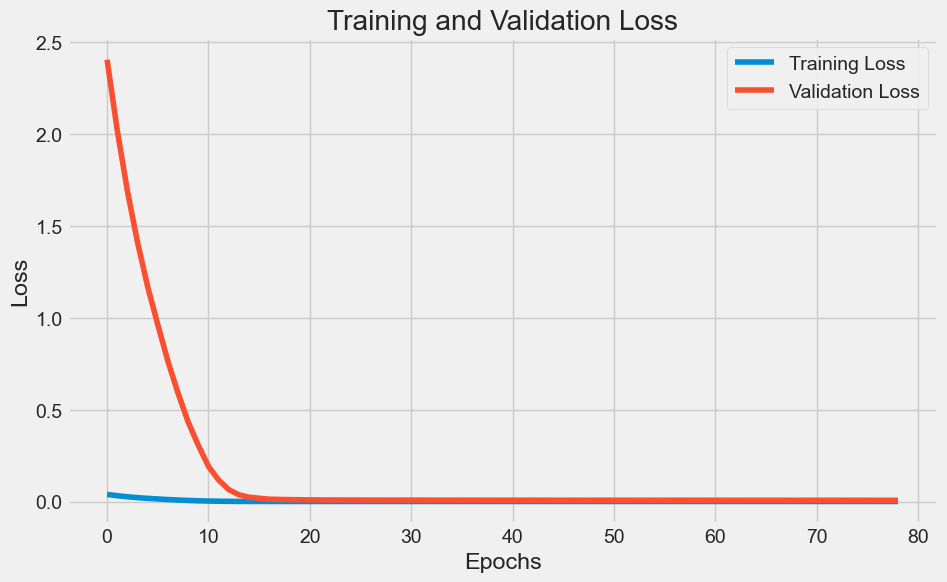

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


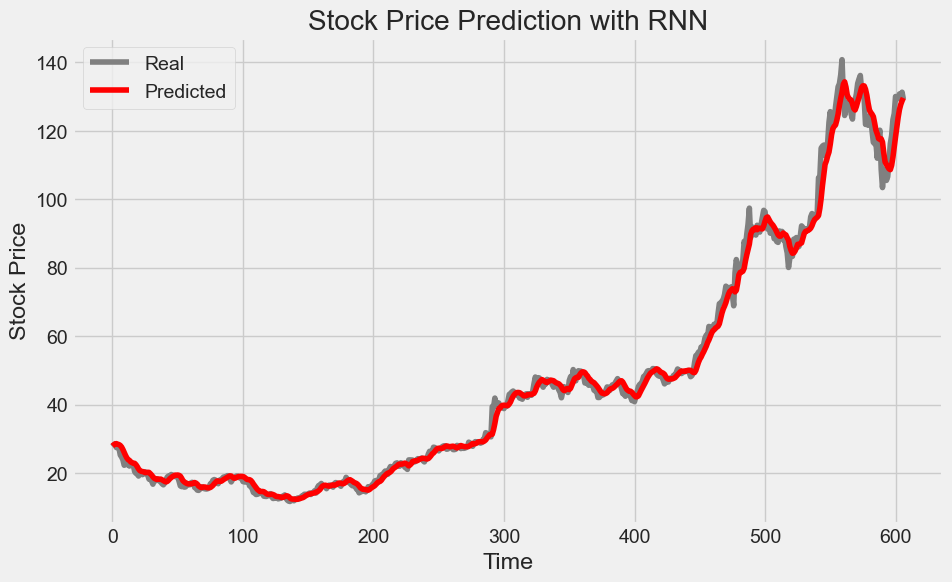

In [13]:
_, _, predicted_stock_price, y_test_scaled = build_and_train_rnn(X_train, y_train, X_test, y_test, optimizer_type='rmsprop', dropout_rate=0)

### Calculate the error for different evaluation metrics

In [14]:
return_evaluation(y_test_scaled, predicted_stock_price)

Mean Squared Error: 7.80
Mean Absolute Error: 1.76
Root Mean Squared Error: 2.79
Mean Absolute Percentage Error: 3.88%


### RNN Conclusion

#### Evaluation Metrics:

- Mean Squared Error (MSE = 7.80): 

This value represents the squared difference between predicted and actual stock prices. While it is slightly higher than previous iterations, it remains relatively low, suggesting that the model captures the overall trend effectively.

- Mean Absolute Error (MAE = 1.76): 

On average, the model’s predictions are $1.76 off from the actual stock prices, demonstrating strong performance in predicting stock price movements.

- Root Mean Squared Error (RMSE = 2.79): 

This metric, which is more sensitive to larger prediction errors, indicates an average deviation of $2.79 from actual prices. Despite being slightly higher than previous runs, it remains within a reasonable range for financial forecasting.

- Mean Absolute Percentage Error (MAPE = 3.88%): 

A MAPE of 3.88% is very good for stock price forecasting, as values below 5% are considered highly accurate in the field.

#### Interpretation:

The graph looks quite good as the model closely follows the actual stock prices, with only minor deviations. The performance is particularly strong during periods of stable growth, and even during more volatile periods, the model tracks the overall trend well. 

The error metrics (especially MAE and MAPE) indicate that the model is making very accurate predictions, with minimal error in terms of both absolute values (dollars) and relative percentage.

# Long-short Term Model **(LSTM)**

In [39]:
def build_and_train_lstm(X_train, y_train, X_test, y_test,
                         n_steps=30,
                         units=300,
                         dropout_rate=0.3,
                         learning_rate=0.0003,
                         epochs=200,
                         batch_size=32,
                         optimizer_type='adam',
                         amsgrad=False,
                         include_early_stopping=True,
                         patience=10,
                         return_sequences=True,
                         title="Stock Price Prediction with LSTM"):
    """
    Builds, trains, and evaluates an LSTM model with customizable parameters.

    Parameters:
        X_train, y_train, X_test, y_test: numpy arrays for training and testing data
        n_steps (int): Number of time steps
        units (int): Number of LSTM units
        dropout_rate (float): Dropout rate for regularization
        learning_rate (float): Learning rate for the optimizer
        epochs (int): Number of training epochs
        batch_size (int): Batch size for training
        optimizer_type (str): Optimizer to use ('adam', 'rmsprop', 'nadam', 'adagrad', 'adadelta', 'sgd')
        include_early_stopping (bool): Whether to include early stopping
        patience (int): Patience for early stopping
        return_sequences (bool): Whether the LSTM should return sequences
        title (str): Title for the prediction plot

    Returns:
        model: Trained LSTM model
        history: Training history object
        predicted_stock_price: Predicted stock prices (inverse transformed)
        y_test_scaled: Real stock prices (inverse transformed)
    """
    # Select optimizer
    optimizer_type = optimizer_type.lower()
    optimizers = {
        'adam': Adam(learning_rate=learning_rate),
        'adam_amsgrad': Adam(learning_rate=learning_rate, amsgrad=amsgrad),  # Adam with AMSGrad
        'rmsprop': RMSprop(learning_rate=learning_rate),
        'nadam': Nadam(learning_rate=learning_rate),
        'adagrad': Adagrad(learning_rate=learning_rate),
        'adadelta': Adadelta(learning_rate=learning_rate),
        'sgd': SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)  # With momentum
    }
    optimizer = optimizers.get(optimizer_type)
    if optimizer is None:
        raise ValueError(f"Unsupported optimizer type: {optimizer_type}")
    
    # Build the LSTM model
    model = Sequential()
    model.add(LSTM(units=units, activation='relu', input_shape=(n_steps, 1), return_sequences=return_sequences))
    model.add(Dropout(dropout_rate))
    if return_sequences:
        model.add(LSTM(units=units, activation='relu'))
    model.add(Dense(units=1))
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Configure callbacks
    callbacks = []
    if include_early_stopping:
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        callbacks.append(early_stopping)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_test, y_test), callbacks=callbacks, verbose=1)
    
    # Plot training and validation loss
    plot_loss(history)
    
    # Predict stock prices
    predicted_stock_price = model.predict(X_test)
    
    # Inverse transform predictions and actual values
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    y_test_scaled = sc.inverse_transform(y_test.reshape(-1, 1))
    
    # Plot predictions
    plot_predictions(y_test_scaled, predicted_stock_price, title)
    
    return model, history, predicted_stock_price, y_test_scaled

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.0128 - val_loss: 0.2298
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 3.1760e-04 - val_loss: 0.0683
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 2.4337e-04 - val_loss: 0.0184
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 2.2831e-04 - val_loss: 0.0141
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 3.5308e-04 - val_loss: 0.0512
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 107ms/step - loss: 2.1874e-04 - val_loss: 0.0677
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 2.3554e-04 - val_loss: 0.1002
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 2.0207e-04 - val_loss: 0.0550
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 1.7391e-04 - val_loss: 0.1931
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 1.7104e-04 - val_loss: 0.1701
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 1.5099e-04 - val_loss: 0.1400
Epo

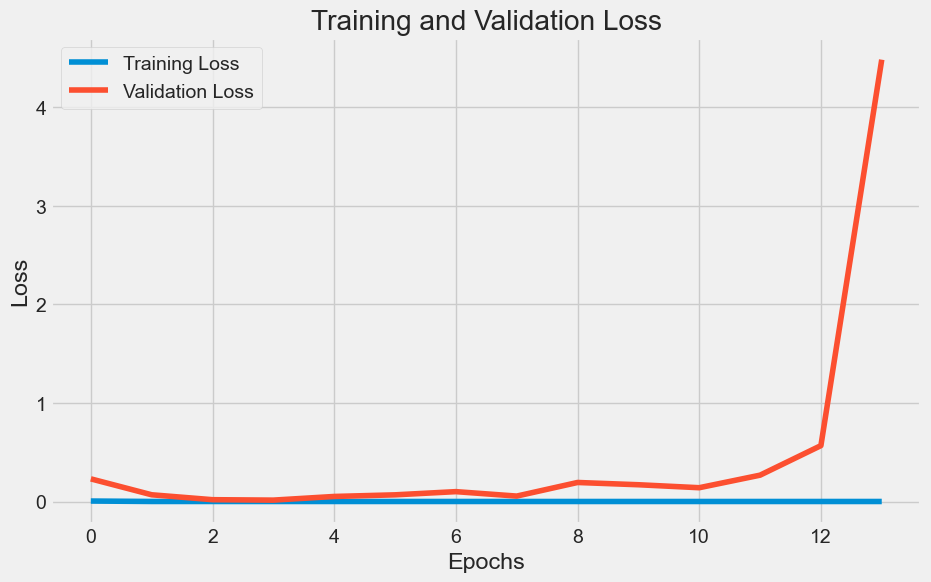

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 39ms/step


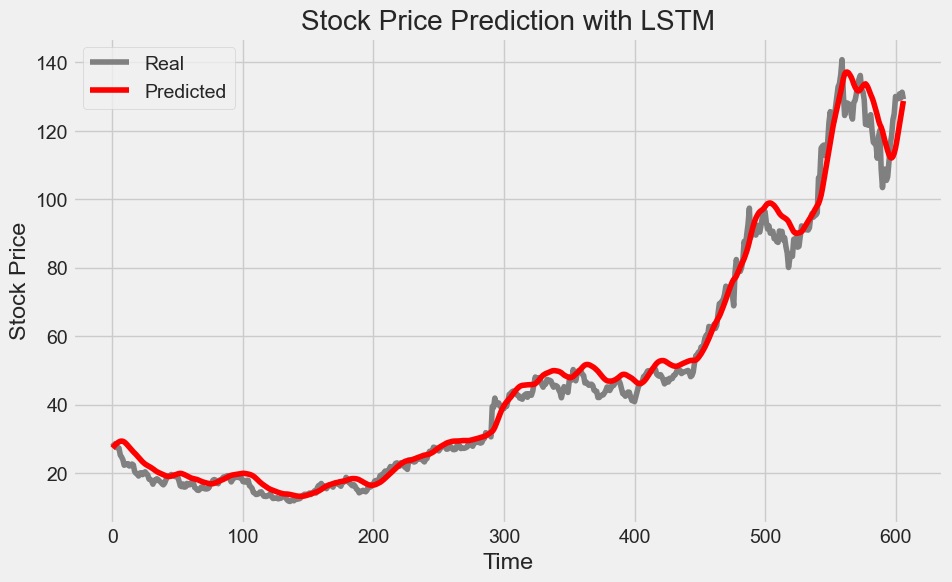

In [16]:
_, _, predicted_stock_price, y_test_scaled = build_and_train_lstm(X_train, y_train, X_test, y_test, optimizer_type='adam', dropout_rate=0)

In [17]:
return_evaluation(y_test_scaled, predicted_stock_price)

Mean Squared Error: 16.67
Mean Absolute Error: 2.93
Root Mean Squared Error: 4.08
Mean Absolute Percentage Error: 7.49%


### Initial LSTM Conclusion
#### Evaluation Metrics:
- Mean Squared Error (MSE = 16.67):

This value indicates a larger discrepancy between predicted and actual stock prices compared to the RNN model, suggesting that the initial LSTM configuration struggles to capture the trends accurately.

- Mean Absolute Error (MAE = 2.93):

On average, the model’s predictions are $2.93 off from the actual stock prices, which is a noticeable increase in error compared to the RNN model.

- Root Mean Squared Error (RMSE = 4.08):

The RMSE highlights that the model’s errors are larger and more significant than the RNN model's, showing reduced performance in capturing the stock price patterns.

- Mean Absolute Percentage Error (MAPE = 7.49%):

A MAPE of 7.49% indicates that the relative error is above the generally acceptable threshold of 5%, further emphasizing the model’s underperformance compared to the RNN.

#### Interpretation:

The initial LSTM configuration, using the Adam optimizer with early stopping, yields worse results than the RNN model in all metrics. This suggests that the current hyperparameter settings may not be optimal for this dataset or that early stopping is prematurely halting training before the model can converge effectively.

To address these issues, the next steps will include experimenting with different optimizers (e.g., RMSprop or SGD) and testing a version of the LSTM model without early stopping to evaluate its impact on performance. Further tuning of hyperparameters, such as the learning rate and number of units, may also improve results.

### LSTM with RMSprop optimizer

We'll try using the RMSprop optimizer, which often works well with recurrent neural networks like LSTM. RMSprop adapts the learning rate based on recent gradients, which can be beneficial for time series data.

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 104ms/step - loss: 0.0163 - val_loss: 0.0470
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - loss: 4.3001e-04 - val_loss: 0.0448
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - loss: 3.1878e-04 - val_loss: 0.0916
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - loss: 4.1718e-04 - val_loss: 0.0368
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - loss: 4.0973e-04 - val_loss: 0.0303
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - loss: 3.4291e-04 - val_loss: 0.0300
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 3.2423e-04 - val_loss: 0.0307
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - loss: 3.3650e-04 - val_loss: 0.0266
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 99ms/step - loss: 2.4682e-04 - val_loss: 0.0278
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - loss: 3.0693e-04 - val_loss: 0.0250
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 98ms/step - loss: 2.8581e-04 - val_loss: 0.0237
Epoch 12/200
93/93 ━━

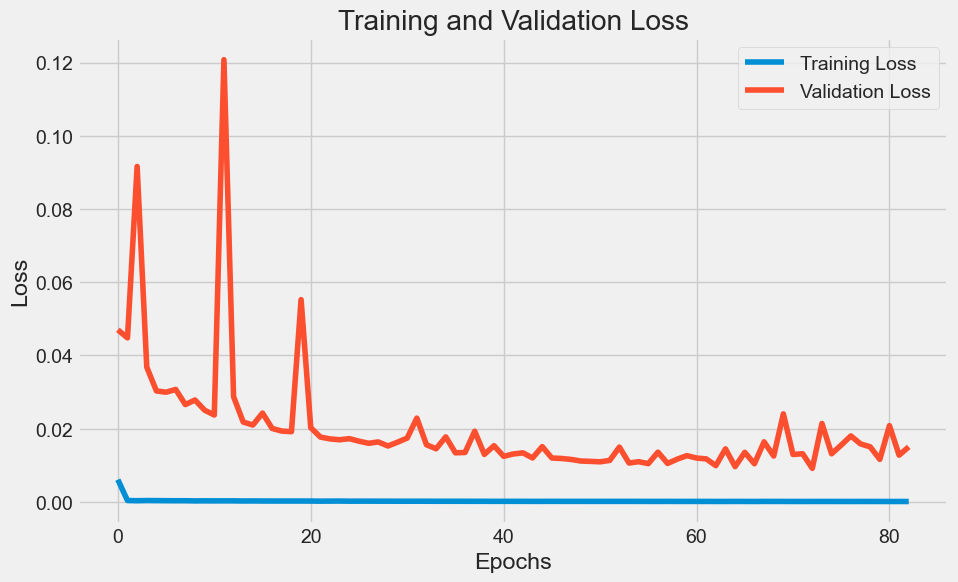

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


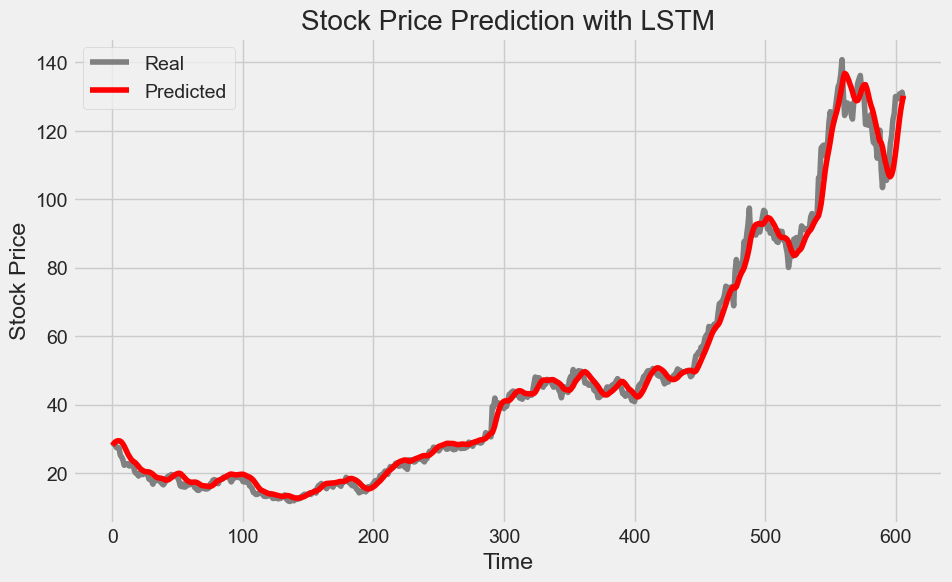

In [18]:
_, _, predicted_stock_price, y_test_scaled = build_and_train_lstm(X_train, y_train, X_test, y_test, n_steps=150, optimizer_type='rmsprop', dropout_rate=0)

In [19]:
return_evaluation(y_test_scaled, predicted_stock_price)

Mean Squared Error: 10.84
Mean Absolute Error: 2.15
Root Mean Squared Error: 3.29
Mean Absolute Percentage Error: 5.02%


### LSTM with RMSprop and Early Stopping Conclusion

### Evaluation Metrics:
- Mean Squared Error (MSE = 10.84):

This value is lower than the initial LSTM with Adam optimizer, indicating improved accuracy in capturing the overall trends of stock price movements.

- Mean Absolute Error (MAE = 2.15):

On average, the model’s predictions are $2.15 off from the actual stock prices, showing a slight improvement over the initial LSTM model but still higher than the RNN.

- Root Mean Squared Error (RMSE = 3.29):

The RMSE indicates an average error of $3.29, which is a reduction compared to the initial LSTM but still higher than the RNN model.

- Mean Absolute Percentage Error (MAPE = 5.02%):

The MAPE value remains above the 5% threshold, showing that while the model's absolute errors improved, its relative error has slightly increased compared to the initial LSTM.

- Interpretation:

Switching to the RMSprop optimizer has led to improved performance across most metrics compared to the initial LSTM configuration with Adam. However, the model still underperforms relative to the RNN model in terms of accuracy and error metrics.

The MAPE suggests that the model struggles with relative accuracy, possibly due to limitations in capturing specific trends or handling volatile data. Future experiments could involve removing early stopping to allow the model more training time or further tuning the optimizer’s learning rate and hyperparameters.

Overall, the LSTM with RMSprop and early stopping demonstrates moderate improvements over the initial configuration, but further optimization is needed to match or exceed the RNN’s performance.

### LSTM with RMSprop optimizer without Early Stopping

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 103ms/step - loss: 0.0112 - val_loss: 0.0363
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 3.7807e-04 - val_loss: 0.0307
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 100ms/step - loss: 3.5788e-04 - val_loss: 0.0297
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 3.3206e-04 - val_loss: 0.0274
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 2.6391e-04 - val_loss: 0.0309
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 3.1369e-04 - val_loss: 0.0270
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 2.8789e-04 - val_loss: 0.0283
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 3.0020e-04 - val_loss: 0.0352
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 3.7125e-04 - val_loss: 0.0226
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 2.6830e-04 - val_loss: 0.0240
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 3.0125e-04 - val_loss: 0.0223
Epoch 12/2

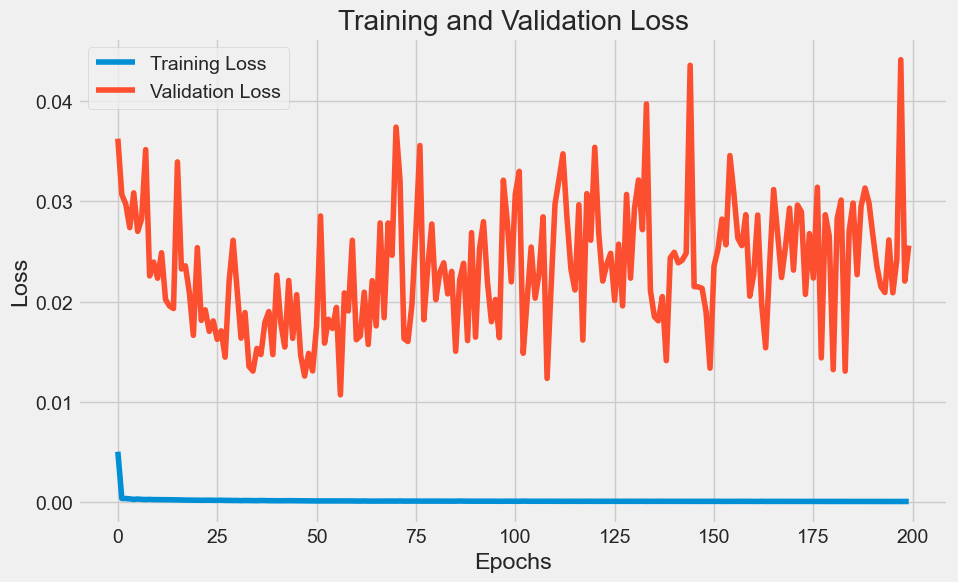

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 38ms/step


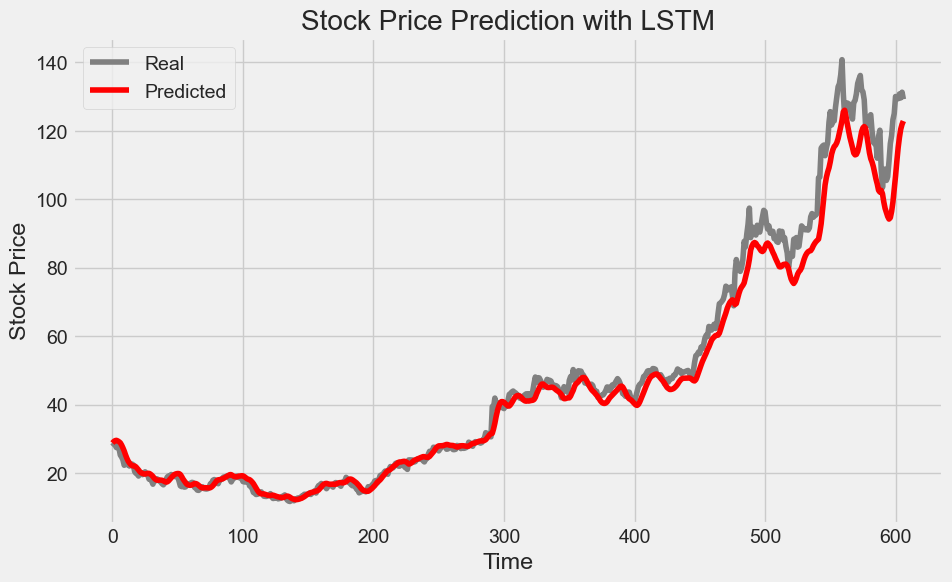

In [20]:
_, _, predicted_stock_price, y_test_scaled = build_and_train_lstm(X_train, y_train, X_test, y_test, n_steps=150, optimizer_type='rmsprop', include_early_stopping=False, dropout_rate=0)

In [21]:
return_evaluation(y_test_scaled, predicted_stock_price)

Mean Squared Error: 30.34
Mean Absolute Error: 3.30
Root Mean Squared Error: 5.51
Mean Absolute Percentage Error: 5.64%


### LSTM with RMSprop and No Early Stopping Conclusion

#### Evaluation Metrics:
- Mean Squared Error (MSE = 30.34):

This significantly higher value indicates that removing early stopping leads to a poorer fit, as the model may overfit to the training data or fail to generalize effectively.

- Mean Absolute Error (MAE = 3.30):

On average, the model’s predictions are $3.30 off from the actual stock prices, showing a notable decline in performance compared to the version with early stopping.

- Root Mean Squared Error (RMSE = 5.51):

The RMSE highlights larger errors in the predictions, further confirming that the absence of early stopping negatively impacts the model’s accuracy.

- Mean Absolute Percentage Error (MAPE = 5.64%):

Although the relative error is slightly lower than the initial LSTM, it is still higher than the LSTM with RMSprop and early stopping, suggesting that this configuration struggles with consistent accuracy.

#### Interpretation:

The results indicate that removing early stopping significantly worsens the performance of the LSTM with RMSprop. While RMSprop is effective at handling sequence data, the lack of early stopping likely led the model to train for too many epochs, causing overfitting and reducing its ability to generalize to unseen data.

Comparatively, the version of LSTM with RMSprop and early stopping achieved the best results among the LSTM configurations, with relatively lower MSE, MAE, RMSE, and MAPE values. This reinforces the importance of early stopping in preventing overfitting and enabling better generalization in this stock prediction task.

Moving forward, further tuning of hyperparameters (e.g., learning rate, number of units) and experimenting with regularization techniques could help improve performance while maintaining the benefits of early stopping.

### LSTM with different Optimizers

We'll experiment with Nadam, Adagrad, Adadelta, SGD with Momentum, and AMSGrad optimizers to see if they perform better than RMSprop

#### Nadam Optimizer

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 130ms/step - loss: 0.0155 - val_loss: 0.0218
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - loss: 2.7201e-04 - val_loss: 0.0475
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - loss: 2.2914e-04 - val_loss: 0.1209
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - loss: 2.0815e-04 - val_loss: 0.2457
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - loss: 1.6040e-04 - val_loss: 0.2123
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 128ms/step - loss: 2.0218e-04 - val_loss: 0.1001
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 129ms/step - loss: 1.2210e-04 - val_loss: 0.3790
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - loss: 1.5836e-04 - val_loss: 0.0556
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - loss: 1.9756e-04 - val_loss: 0.1549
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - loss: 1.5281e-04 - val_loss: 4.9516
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 127ms/step - loss: 1.2470e-04 - val_loss: 320.5607


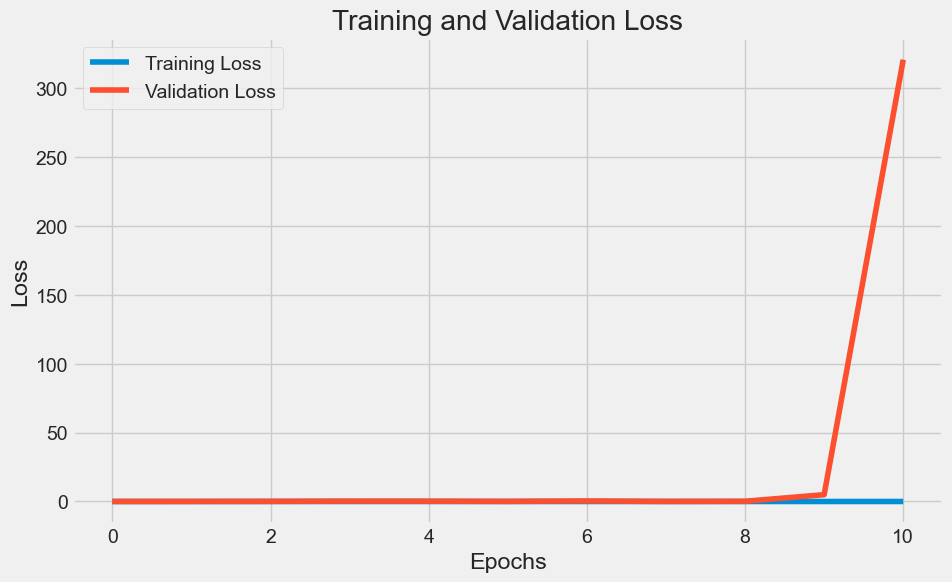

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


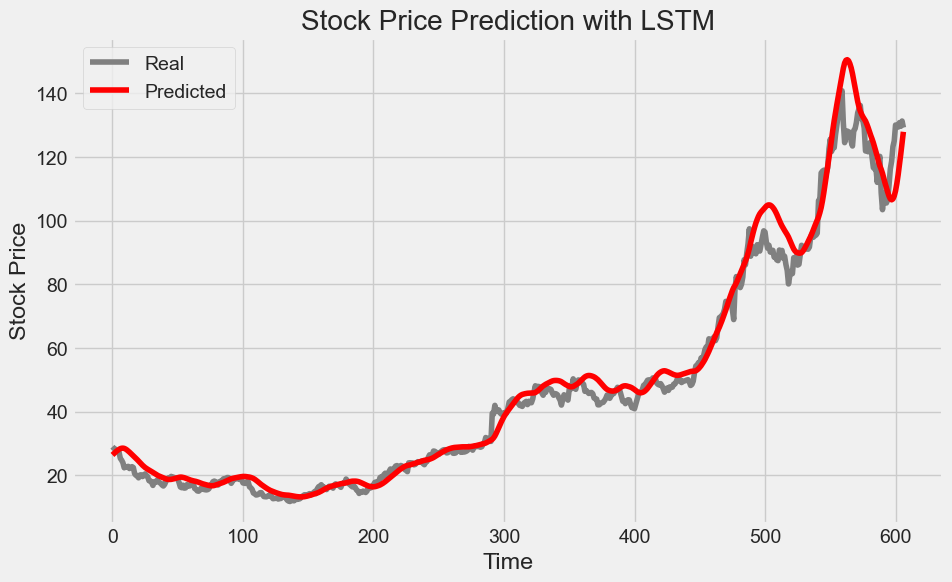

In [22]:
_, _, predicted_stock_price, y_test_scaled = build_and_train_lstm(X_train, y_train, X_test, y_test, n_steps=150, optimizer_type='nadam', dropout_rate=0)

In [23]:
return_evaluation(y_test_scaled, predicted_stock_price)

Mean Squared Error: 25.77
Mean Absolute Error: 3.24
Root Mean Squared Error: 5.08
Mean Absolute Percentage Error: 7.53%


#### Adagrad Optimizer

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 130ms/step - loss: 0.0433 - val_loss: 2.9441
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - loss: 0.0413 - val_loss: 2.8850
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - loss: 0.0404 - val_loss: 2.8365
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - loss: 0.0338 - val_loss: 2.7949
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - loss: 0.0292 - val_loss: 2.7578
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 0.0327 - val_loss: 2.7241
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - loss: 0.0295 - val_loss: 2.6930
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - loss: 0.0303 - val_loss: 2.6641
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - loss: 0.0270 - val_loss: 2.6367
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - loss: 0.0287 - val_loss: 2.6113
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - loss: 0.0279 - val_loss: 2.5872
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11

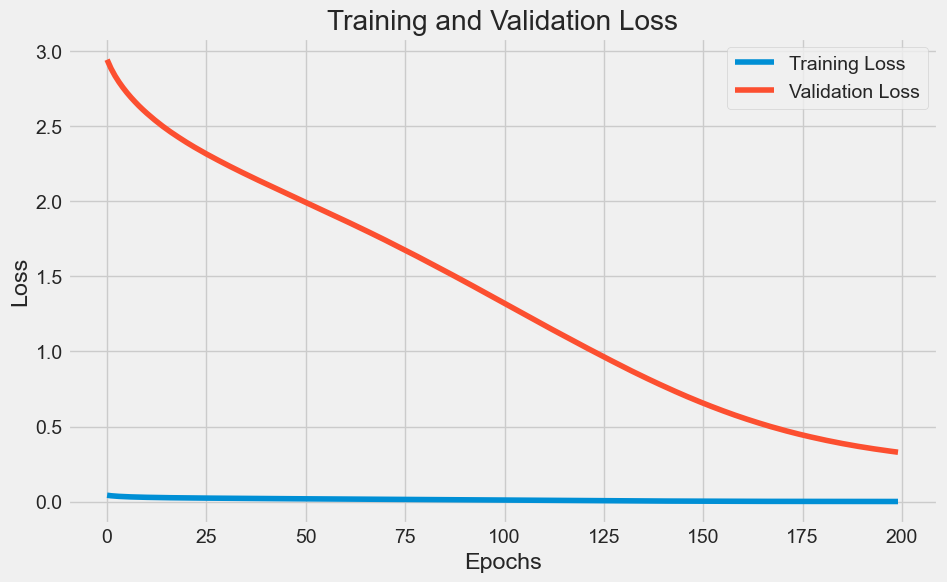

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 50ms/step


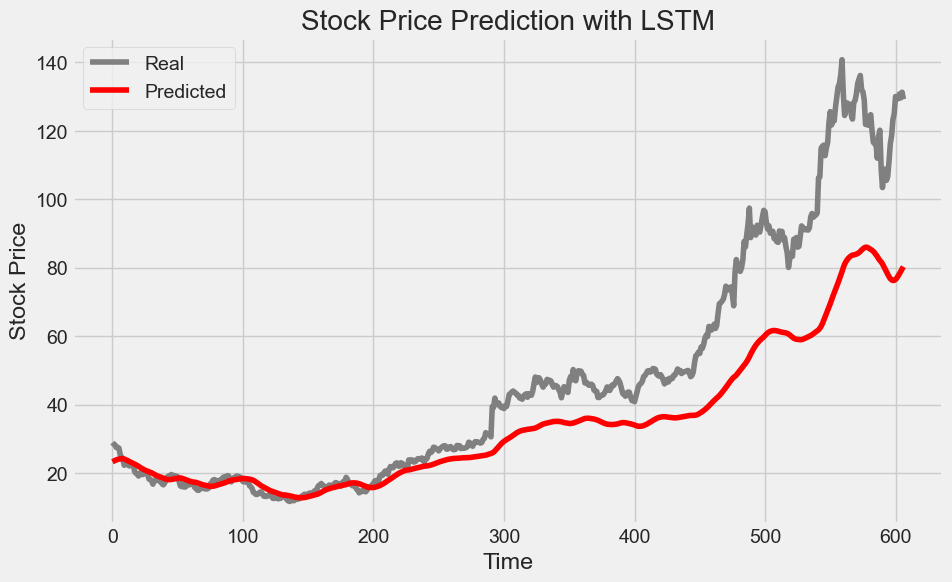

In [24]:
_, _, predicted_stock_price, y_test_scaled = build_and_train_lstm(X_train, y_train, X_test, y_test, n_steps=150, optimizer_type='adagrad', dropout_rate=0)

In [25]:
return_evaluation(y_test_scaled, predicted_stock_price)

Mean Squared Error: 389.70
Mean Absolute Error: 13.07
Root Mean Squared Error: 19.74
Mean Absolute Percentage Error: 20.20%


#### Adadelta Optimizer

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 14s 135ms/step - loss: 0.0425 - val_loss: 2.7933
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 123ms/step - loss: 0.0447 - val_loss: 2.7847
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 124ms/step - loss: 0.0400 - val_loss: 2.7760
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - loss: 0.0385 - val_loss: 2.7671
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - loss: 0.0429 - val_loss: 2.7582
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - loss: 0.0399 - val_loss: 2.7493
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - loss: 0.0369 - val_loss: 2.7403
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - loss: 0.0393 - val_loss: 2.7315
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 121ms/step - loss: 0.0365 - val_loss: 2.7227
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - loss: 0.0402 - val_loss: 2.7140
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11s 122ms/step - loss: 0.0376 - val_loss: 2.7053
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 11

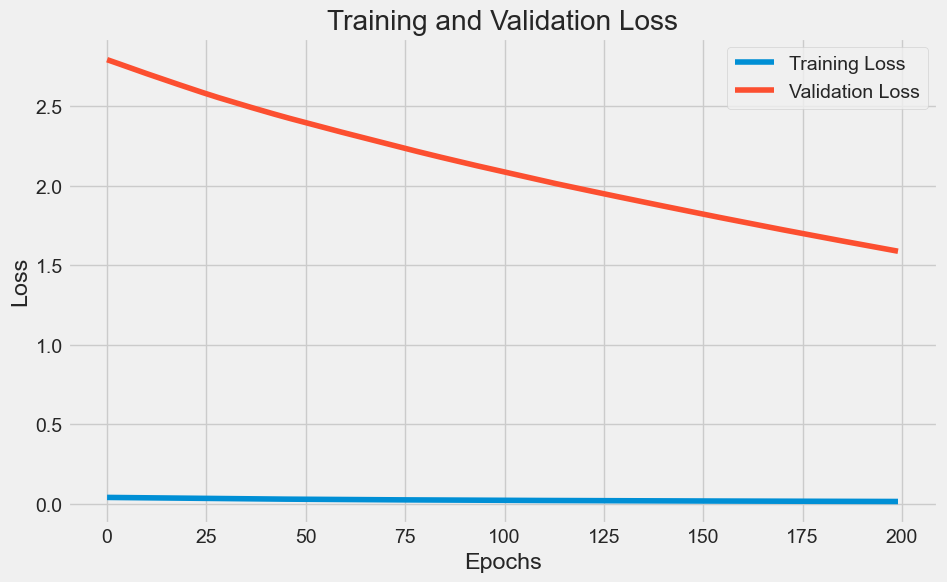

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step


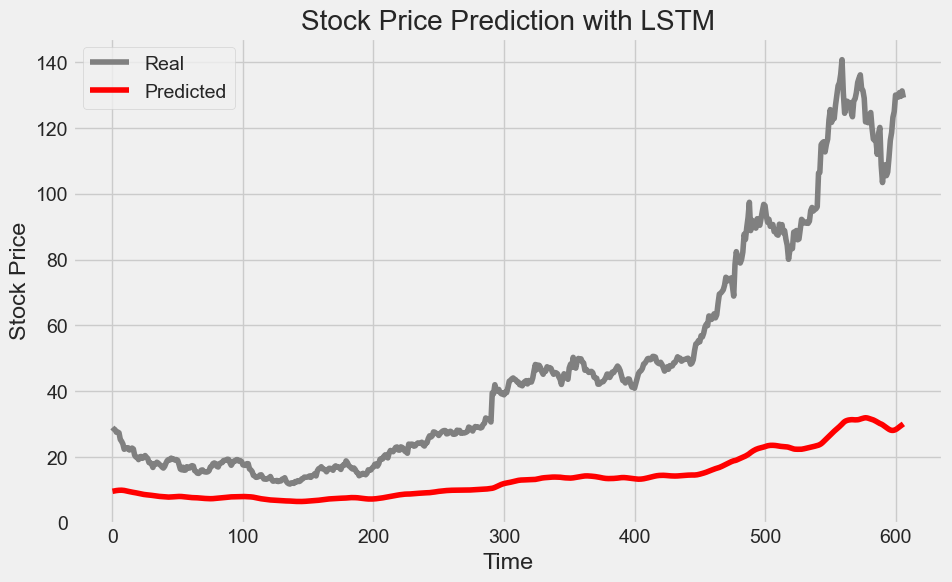

In [26]:
_, _, predicted_stock_price, y_test_scaled = build_and_train_lstm(X_train, y_train, X_test, y_test, n_steps=150, optimizer_type='adadelta', dropout_rate=0)

In [27]:
return_evaluation(y_test_scaled, predicted_stock_price)

Mean Squared Error: 1882.95
Mean Absolute Error: 33.32
Root Mean Squared Error: 43.39
Mean Absolute Percentage Error: 65.31%


#### SGD with Momentum Optimizer

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - loss: 0.0445 - val_loss: 2.6901
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - loss: 0.0306 - val_loss: 2.5552
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - loss: 0.0253 - val_loss: 2.4828
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - loss: 0.0256 - val_loss: 2.4346
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - loss: 0.0237 - val_loss: 2.3914
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - loss: 0.0228 - val_loss: 2.3557
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - loss: 0.0231 - val_loss: 2.3214
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 134ms/step - loss: 0.0238 - val_loss: 2.2908
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 134ms/step - loss: 0.0211 - val_loss: 2.2623
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - loss: 0.0222 - val_loss: 2.2334
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 135ms/step - loss: 0.0226 - val_loss: 2.2034
Epoch 12/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 13

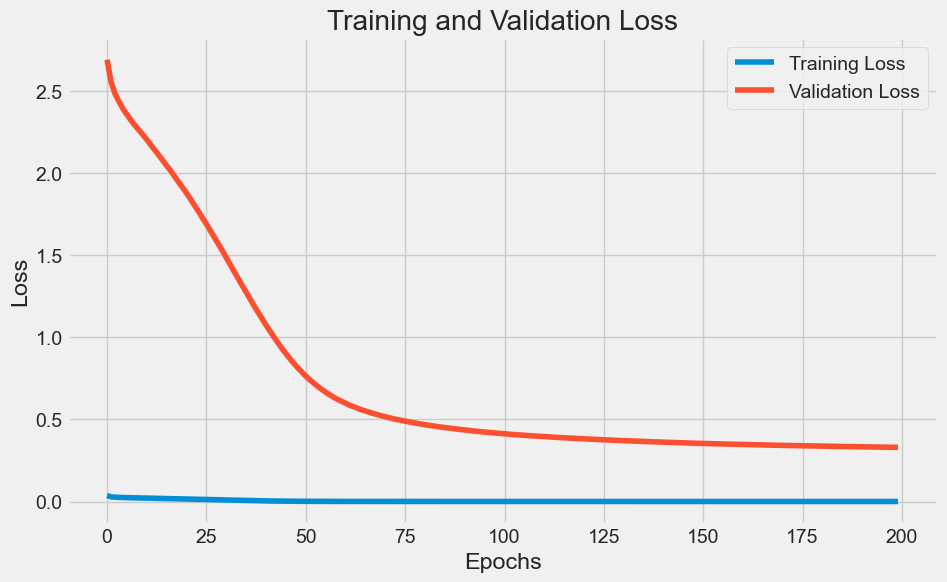

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


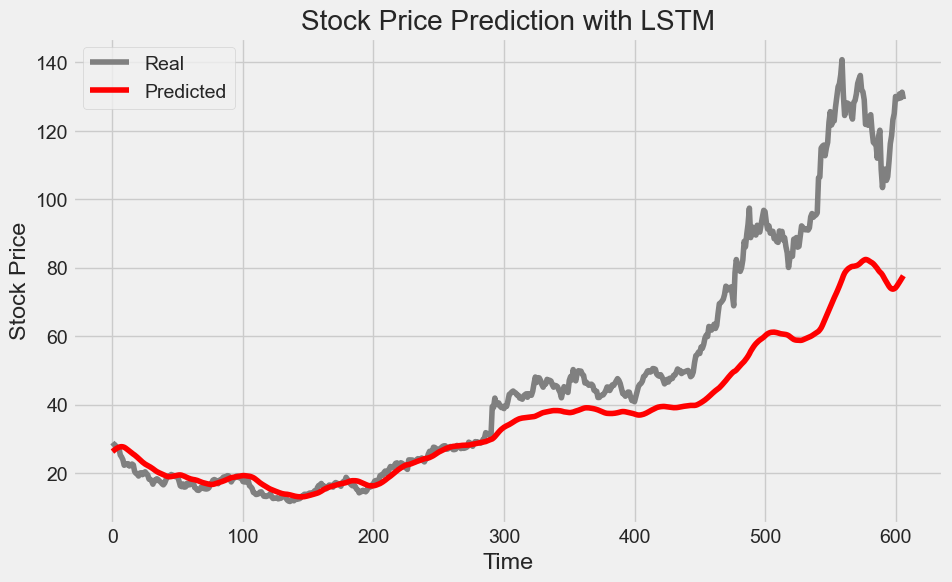

In [28]:
_, _, predicted_stock_price, y_test_scaled = build_and_train_lstm(X_train, y_train, X_test, y_test, n_steps=150, optimizer_type='sgd', dropout_rate=0)

In [29]:
return_evaluation(y_test_scaled, predicted_stock_price)

Mean Squared Error: 390.91
Mean Absolute Error: 12.17
Root Mean Squared Error: 19.77
Mean Absolute Percentage Error: 17.89%


#### Adam with AMSgrad Optimizer

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 15s 140ms/step - loss: 0.0154 - val_loss: 51.9894
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - loss: 2.6299e-04 - val_loss: 0.5390
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - loss: 3.5675e-04 - val_loss: 0.1069
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - loss: 2.4951e-04 - val_loss: 0.0310
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - loss: 2.0512e-04 - val_loss: 0.0115
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - loss: 2.1560e-04 - val_loss: 0.0370
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - loss: 2.1480e-04 - val_loss: 0.0690
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - loss: 1.3183e-04 - val_loss: 0.1616
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - loss: 1.5489e-04 - val_loss: 0.2055
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 140ms/step - loss: 1.4234e-04 - val_loss: 0.1598
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 13s 139ms/step - loss: 2.0758e-04 - val_loss: 0.1540
E

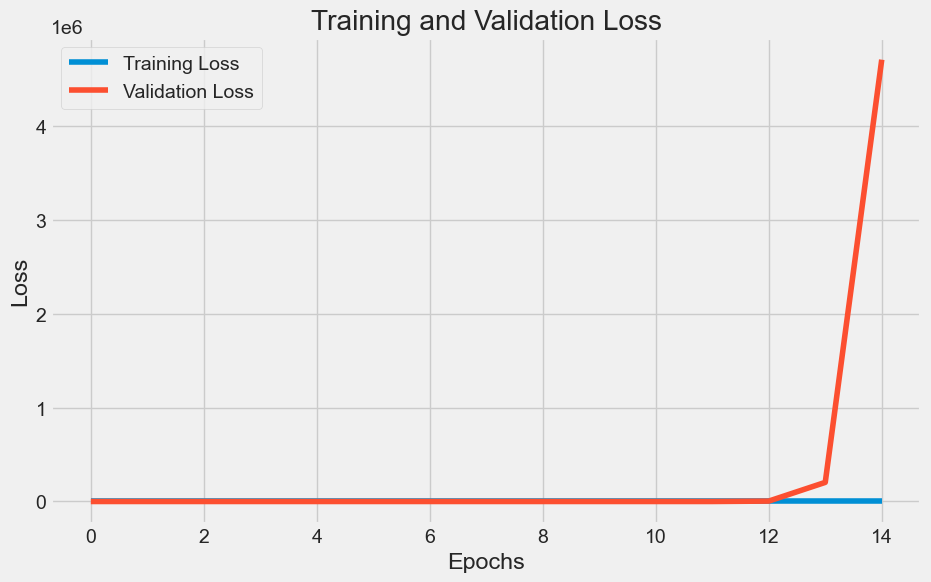

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 56ms/step


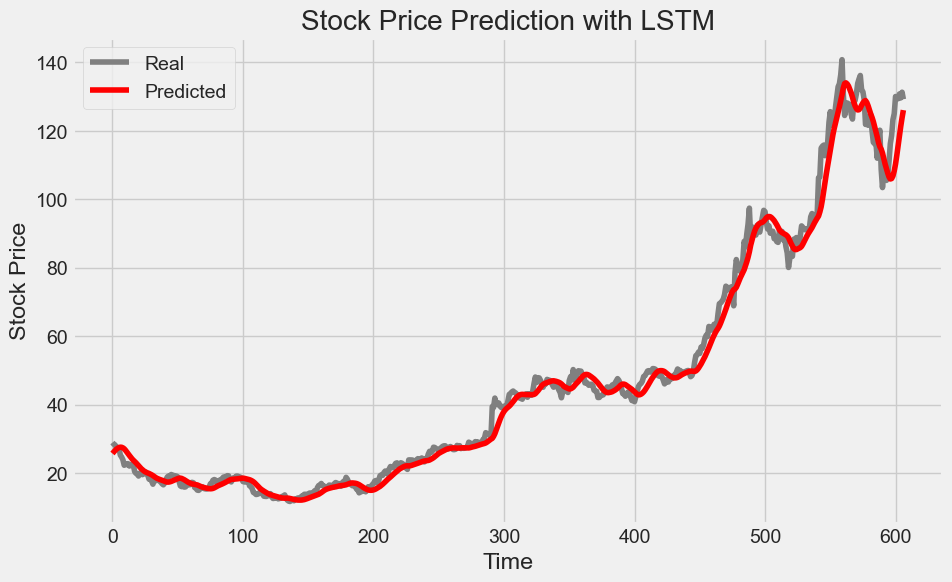

In [30]:
_, _, predicted_stock_price, y_test_scaled = build_and_train_lstm(X_train, y_train, X_test, y_test, n_steps=150, optimizer_type='adam_amsgrad', amsgrad=True, dropout_rate=0)

In [31]:
return_evaluation(y_test_scaled, predicted_stock_price)

Mean Squared Error: 13.65
Mean Absolute Error: 2.48
Root Mean Squared Error: 3.69
Mean Absolute Percentage Error: 5.72%


## Bi-Directional LSTM with RMSprop Optimizer

In [40]:
def build_and_train_bilstm(X_train, y_train, X_test, y_test,
                           n_steps=150,
                           units=300,
                           dropout_rate=0.3,
                           learning_rate=0.0005,
                           epochs=200,
                           batch_size=32,
                           optimizer_type='rmsprop',
                           include_early_stopping=True,
                           patience=10,
                           return_sequences=True,
                           title="Stock Price Prediction with Bi-Directional LSTM"):
    """
    Builds, trains, and evaluates a Bi-Directional LSTM model with customizable parameters.

    Parameters:
        X_train, y_train, X_test, y_test: numpy arrays for training and testing data
        n_steps (int): Number of time steps
        units (int): Number of Bi-LSTM units
        dropout_rate (float): Dropout rate for regularization
        learning_rate (float): Learning rate for the optimizer
        epochs (int): Number of training epochs
        batch_size (int): Batch size for training
        optimizer_type (str): Optimizer to use ('adam', 'rmsprop', 'nadam', etc.)
        include_early_stopping (bool): Whether to include early stopping
        patience (int): Patience for early stopping
        return_sequences (bool): Whether the Bi-LSTM should return sequences
        title (str): Title for the prediction plot

    Returns:
        model: Trained Bi-LSTM model
        history: Training history object
        predicted_stock_price: Predicted stock prices (inverse transformed)
        y_test_scaled: Real stock prices (inverse transformed)
    """
    # Select optimizer
    optimizer_type = optimizer_type.lower()
    optimizers = {
        'adam': Adam(learning_rate=learning_rate),
        'rmsprop': RMSprop(learning_rate=learning_rate),
        'nadam': Nadam(learning_rate=learning_rate),
        'adagrad': Adagrad(learning_rate=learning_rate),
        'adadelta': Adadelta(learning_rate=learning_rate),
        'sgd': SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
    }
    optimizer = optimizers.get(optimizer_type)
    if optimizer is None:
        raise ValueError(f"Unsupported optimizer type: {optimizer_type}")
    
    # Build the Bi-LSTM model
    model = Sequential()
    model.add(Bidirectional(LSTM(units=units, activation='relu', return_sequences=return_sequences), input_shape=(n_steps, 1)))
    model.add(Dropout(dropout_rate))
    if return_sequences:
        model.add(Bidirectional(LSTM(units=units, activation='relu')))
    model.add(Dense(units=1))
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Configure callbacks
    callbacks = []
    if include_early_stopping:
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        callbacks.append(early_stopping)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_test, y_test), callbacks=callbacks, verbose=1)
    
    # Plot training and validation loss
    plot_loss(history)
    
    # Predict stock prices
    predicted_stock_price = model.predict(X_test)
    
    # Inverse transform predictions and actual values
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    y_test_scaled = sc.inverse_transform(y_test.reshape(-1, 1))
    
    # Plot predictions
    plot_predictions(y_test_scaled, predicted_stock_price, title)
    
    return model, history, predicted_stock_price, y_test_scaled

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 36s 350ms/step - loss: 0.0102 - val_loss: 0.0576
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 32s 340ms/step - loss: 5.1823e-04 - val_loss: 0.0481
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 32s 348ms/step - loss: 6.0333e-04 - val_loss: 0.0436
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 32s 348ms/step - loss: 3.7261e-04 - val_loss: 0.0483
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 33s 351ms/step - loss: 3.0249e-04 - val_loss: 0.0390
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 33s 354ms/step - loss: 3.3273e-04 - val_loss: 0.0548
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 32s 347ms/step - loss: 5.6973e-04 - val_loss: 0.0254
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 32s 349ms/step - loss: 2.8523e-04 - val_loss: 0.0336
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 32s 347ms/step - loss: 2.7737e-04 - val_loss: 0.0594
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 32s 348ms/step - loss: 3.2969e-04 - val_loss: 0.0285
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 32s 348ms/step - loss: 2.3791e-04 - val_loss: 0.0191
Ep

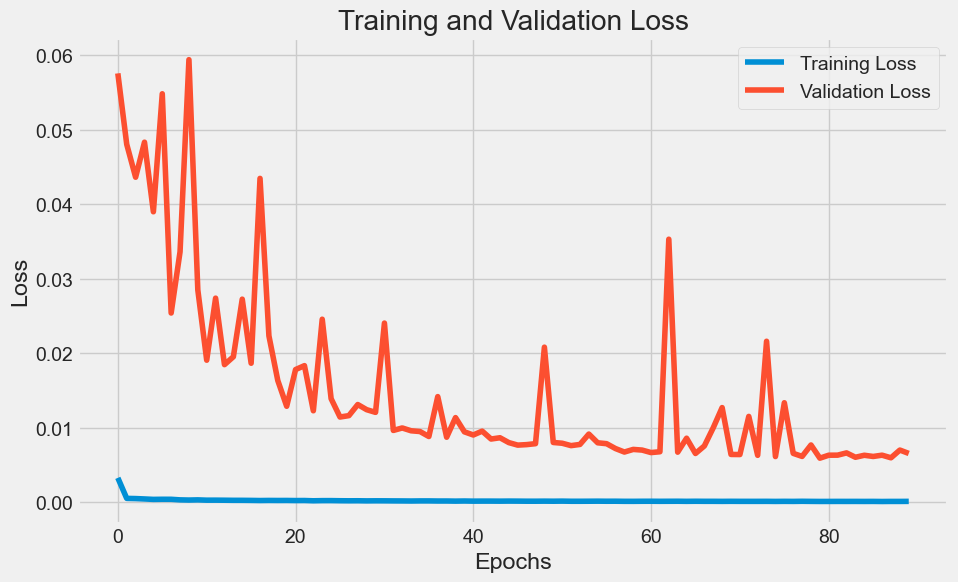

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 100ms/step


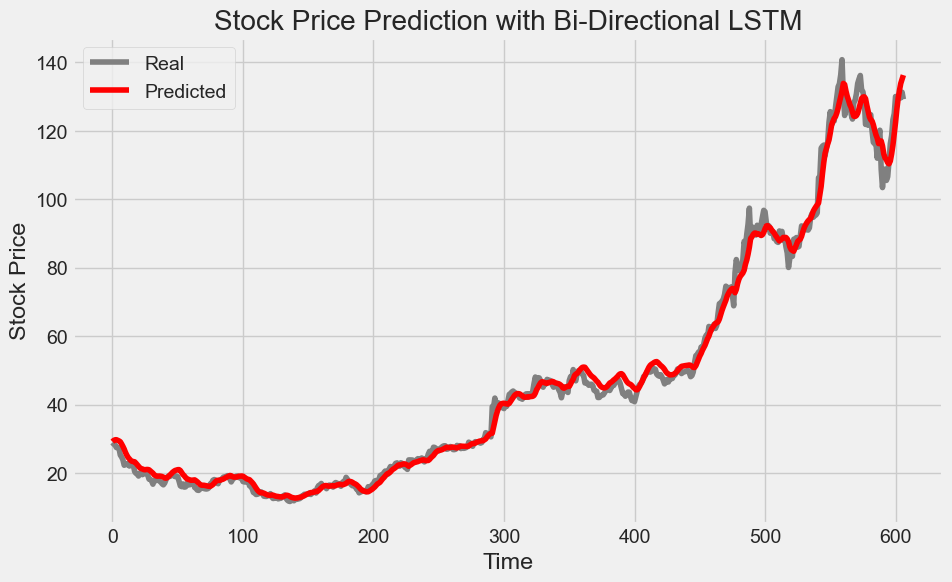

In [33]:
_, _, predicted_stock_price, y_test_scaled = build_and_train_bilstm(X_train, y_train, X_test, y_test, optimizer_type='rmsprop', dropout_rate=0)

In [34]:
return_evaluation(y_test_scaled, predicted_stock_price)

Mean Squared Error: 7.00
Mean Absolute Error: 1.82
Root Mean Squared Error: 2.65
Mean Absolute Percentage Error: 4.51%


## Final Conclusion for LSTM

### Performance Summary:
Based on the tested configurations, the following insights were observed:

1. **RMSprop Optimizer with Early Stopping:**  
   RMSprop remains a strong contender, achieving relatively low error values in most metrics. When paired with Bi-Directional LSTM, it delivered the best performance among all LSTM variants:
   - **Bi-Directional LSTM with RMSprop:**
     - MSE: 7.00
     - MAE: 1.82
     - RMSE: 2.65
     - MAPE: 4.51%
   - These results outperform all standard LSTMs and demonstrate the added benefit of leveraging a Bi-Directional architecture to improve temporal learning.

2. **Nadam Optimizer with Early Stopping:**  
   The Nadam optimizer produced mixed results:
   - MSE: 25.77
   - MAE: 3.24
   - RMSE: 5.08
   - MAPE: 7.53%
   - While slightly better than Adagrad, Adadelta, and SGD with momentum, it fell short of the performance achieved by RMSprop.

3. **Adam + AMSGrad Optimizer with Early Stopping:**  
   Adding AMSGrad to Adam provided marginal improvements over standard Adam:
   - MSE: 13.65
   - MAE: 2.48
   - RMSE: 3.69
   - MAPE: 5.72%
   - While a step forward, it still underperformed compared to RMSprop and Bi-Directional LSTM.

4. **Other Optimizers:**
   - **Adagrad:**  
     - MSE: 389.70, MAE: 13.07, RMSE: 19.74, MAPE: 20.20%  
     - The Adagrad optimizer struggled significantly, resulting in high error values and poor generalization.
   - **Adadelta:**  
     - MSE: 1882.95, MAE: 33.32, RMSE: 43.39, MAPE: 65.31%  
     - Adadelta was the least effective, with extreme errors across all metrics.
   - **SGD with Momentum:**  
     - MSE: 390.91, MAE: 12.17, RMSE: 19.77, MAPE: 17.89%  
     - While slightly better than Adagrad and Adadelta, SGD with momentum underperformed compared to RMSprop and Adam-based optimizers.

### Interpretation:
- **Bi-Directional LSTM:**  
  Bi-Directional LSTM with RMSprop achieved the best overall performance, particularly in MSE, MAE, and MAPE. This highlights the effectiveness of a Bi-Directional architecture in capturing bidirectional dependencies in time-series data, resulting in improved forecasting accuracy.

- **Optimizer Selection:**  
  RMSprop remains the most effective optimizer for both standard and Bi-Directional LSTM models. Adam with AMSGrad shows potential but does not outperform RMSprop. Adagrad, Adadelta, and SGD with momentum fail to generalize effectively for this dataset.

### Comparison with RNN:
While LSTM models have shown improved performance through optimization and the use of a Bi-Directional architecture, the RNN model still outperformed most LSTM variants on this specific NVIDIA stock dataset. The Bi-Directional LSTM with RMSprop comes closest to matching RNN performance and may surpass it when applied to datasets with more complex temporal patterns.

### Conclusion:
LSTM and Bi-Directional LSTM models are viable alternatives to RNN for time-series forecasting, especially when optimized with suitable hyperparameters and architectures. The Bi-Directional LSTM with RMSprop stands out as the best-performing LSTM configuration. However, the RNN model remains a strong baseline for this dataset. Further testing on additional datasets is necessary to determine if these findings generalize or if the observed performance trends are unique to NVIDIA stock data.


# Gated Recurrent Unit (GRU)

In [12]:
def build_and_train_gru(X_train, y_train, X_test, y_test,
                        n_steps=150,
                        units=300,
                        dropout_rate=0.3,
                        learning_rate=0.0003,
                        epochs=200,
                        batch_size=32,
                        optimizer_type='rmsprop',
                        include_early_stopping=True,
                        patience=10,
                        return_sequences=True,
                        title="Stock Price Prediction with GRU"):
    """
    Builds, trains, and evaluates a GRU model with customizable parameters.

    Parameters:
        X_train, y_train, X_test, y_test: numpy arrays for training and testing data
        n_steps (int): Number of time steps
        units (int): Number of GRU units
        dropout_rate (float): Dropout rate for regularization
        learning_rate (float): Learning rate for the optimizer
        epochs (int): Number of training epochs
        batch_size (int): Batch size for training
        optimizer_type (str): Optimizer to use ('adam', 'rmsprop', 'nadam', etc.)
        include_early_stopping (bool): Whether to include early stopping
        patience (int): Patience for early stopping
        return_sequences (bool): Whether the GRU should return sequences
        title (str): Title for the prediction plot

    Returns:
        model: Trained GRU model
        history: Training history object
        predicted_stock_price: Predicted stock prices (inverse transformed)
        y_test_scaled: Real stock prices (inverse transformed)
    """
    # Select optimizer
    optimizer_type = optimizer_type.lower()
    optimizers = {
        'adam': Adam(learning_rate=learning_rate),
        'rmsprop': RMSprop(learning_rate=learning_rate),
        'nadam': Nadam(learning_rate=learning_rate),
        'adagrad': Adagrad(learning_rate=learning_rate),
        'adadelta': Adadelta(learning_rate=learning_rate),
        'sgd': SGD(learning_rate=learning_rate, momentum=0.9, nesterov=True)
    }
    optimizer = optimizers.get(optimizer_type)
    if optimizer is None:
        raise ValueError(f"Unsupported optimizer type: {optimizer_type}")
    
    # Build the GRU model
    model = Sequential()
    model.add(GRU(units=units, activation='relu', input_shape=(n_steps, 1), return_sequences=return_sequences))
    model.add(Dropout(dropout_rate))
    if return_sequences:
        model.add(GRU(units=units, activation='relu'))
    model.add(Dense(units=1))
    
    # Compile the model
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    # Configure callbacks
    callbacks = []
    if include_early_stopping:
        early_stopping = EarlyStopping(monitor='val_loss', patience=patience, restore_best_weights=True)
        callbacks.append(early_stopping)
    
    # Train the model
    history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                        validation_data=(X_test, y_test), callbacks=callbacks, verbose=1)
    
    # Plot training and validation loss
    plot_loss(history)
    
    # Predict stock prices
    predicted_stock_price = model.predict(X_test)
    
    # Inverse transform predictions and actual values
    predicted_stock_price = sc.inverse_transform(predicted_stock_price)
    y_test_scaled = sc.inverse_transform(y_test.reshape(-1, 1))
    
    # Plot predictions
    plot_predictions(y_test_scaled, predicted_stock_price, title)
    
    return model, history, predicted_stock_price, y_test_scaled


Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 106ms/step - loss: 0.0125 - val_loss: 0.0580
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 1.4366e-04 - val_loss: 0.0490
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 1.3048e-04 - val_loss: 0.0438
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 102ms/step - loss: 1.6812e-04 - val_loss: 0.0402
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 101ms/step - loss: 1.4441e-04 - val_loss: 0.0442
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 1.4858e-04 - val_loss: 0.0392
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 108ms/step - loss: 1.2481e-04 - val_loss: 0.0363
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 103ms/step - loss: 1.1577e-04 - val_loss: 0.0348
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 9s 102ms/step - loss: 1.1978e-04 - val_loss: 0.0337
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 1.3243e-04 - val_loss: 0.0330
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 104ms/step - loss: 1.2265e-04 - val_loss: 0.0365
Epoch 1

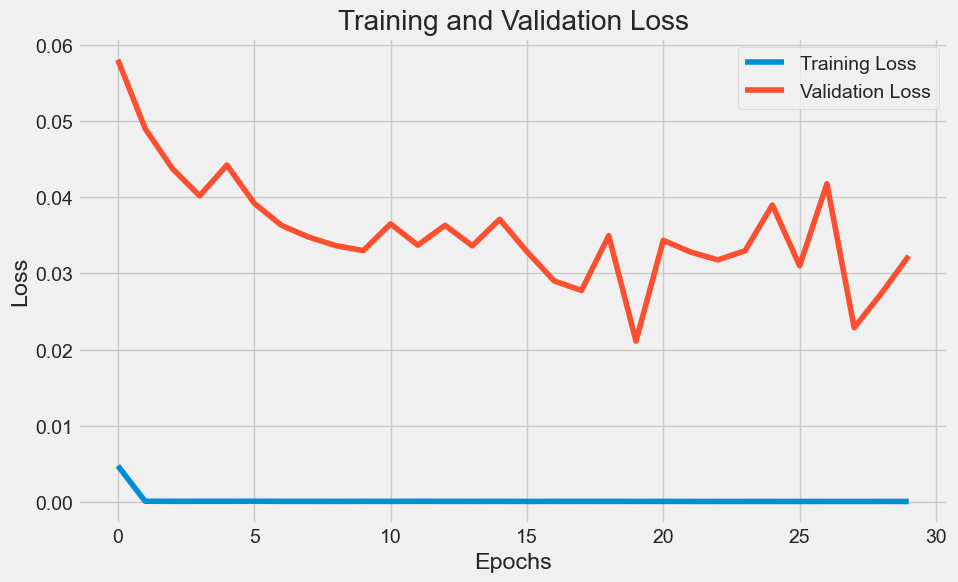

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step


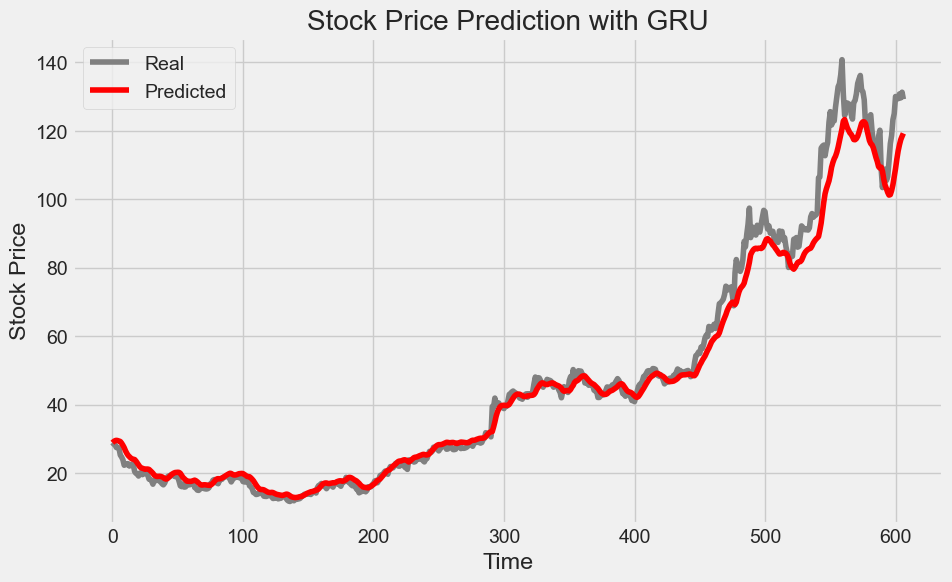

In [16]:
_, _, predicted_stock_price, y_test_scaled = build_and_train_gru(X_train, y_train, X_test, y_test, optimizer_type='rmsprop', dropout_rate=0)

In [17]:
return_evaluation(y_test_scaled, predicted_stock_price)

Mean Squared Error: 25.03
Mean Absolute Error: 3.03
Root Mean Squared Error: 5.00
Mean Absolute Percentage Error: 6.01%


## GRU Conclusion

### Performance Summary:
The GRU model was tested on NVIDIA stock prices with a dropout rate of **0%**, yielding the following metrics:
- **Mean Squared Error (MSE):** 25.03  
- **Mean Absolute Error (MAE):** 3.03  
- **Root Mean Squared Error (RMSE):** 5.00  
- **Mean Absolute Percentage Error (MAPE):** 6.01%  

Compared to previous runs, these results indicate that removing dropout increased the model’s error across all metrics. This suggests that dropout played a crucial role in preventing overfitting, and removing it led to a decrease in model performance.

### Strengths:
- **Still Competitive:** Despite the increased error, GRU remains a viable deep learning model for NVIDIA stock prediction, performing within an acceptable range.
- **Efficient Training:** GRU continues to offer computational efficiency over LSTM-based models.

### Weaknesses:
- **Increased Error:** The removal of dropout led to a higher MSE, MAE, and RMSE, suggesting that regularization is essential for preventing overfitting in this configuration.
- **Higher Relative Error:** The MAPE increased from **5.37% to 6.01%**, indicating that the model is less accurate at predicting percentage-based price changes.

### Comparison with Other Models:
- **Versus RNN:** The updated GRU model now underperforms compared to the RNN model in both absolute and percentage-based errors.
- **Versus LSTM:** GRU was previously competitive with Bi-Directional LSTM, but this iteration shows that removing dropout negatively impacted its performance.

### Conclusion:
The updated GRU results confirm that dropout is useful for maintaining predictive accuracy in this model in specific cases. Removing dropout increased all error metrics for GRU, but also decreased all error metrics for RNN and LSTM. While GRU remains a viable model for stock price prediction, the previous configuration (with dropout) performed significantly better. 

Based on these findings, reintroducing dropout or further tuning hyperparameters would be necessary to restore GRU’s competitive advantage. Further testing across datasets will help determine the optimal balance between regularization and predictive accuracy.

# Autoregressive Integrated Moving Average (ARIMA)

## Key Differences from Neural Networks

| **Feature**            | **ARIMA**                         | **RNN, LSTM, GRU**                  |
|-------------------------|------------------------------------|--------------------------------------|
| **Type of Model**       | Statistical                      | Machine Learning (Neural Networks)  |
| **Data Requirements**   | Requires stationary data         | Can handle non-stationary data       |
| **Interpretability**    | Highly interpretable             | Black-box nature                    |
| **Handling Trends**     | Uses differencing (manual)       | Learns trends automatically         |
| **Feature Engineering** | Univariate (simple)              | Multivariate (can include additional features) |
| **Performance**         | Best for linear relationships    | Excels in capturing non-linear patterns |


## Steps to Apply ARIMA

1. Check Stationarity:

- Use the Augmented Dickey-Fuller (ADF) test to check if the series is stationary.
- If the p-value is greater than 0.05, the series is not stationary, and differencing is needed.

2. Determine the Order (p, d, q):

- p: Determined from the Partial AutoCorrelation Function (PACF) plot. Peaks in the PACF at lag k suggest potential values for p.
- d: Determined by differencing until the series becomes stationary.
- q: Determined from the AutoCorrelation Function (ACF) plot. Peaks in the ACF suggest potential values for q.

3. Fit the ARIMA Model:

- Use the identified parameters (p, d, q) to fit the model.

4. Evaluate Residuals:

- Check if the residuals (errors) are white noise (random) using the Ljung-Box test or residual plots.

5. Forecast:

- Use the fitted ARIMA model to predict future values.

ADF Statistic (Original Series): 4.788776183021694, p-value: 1.0


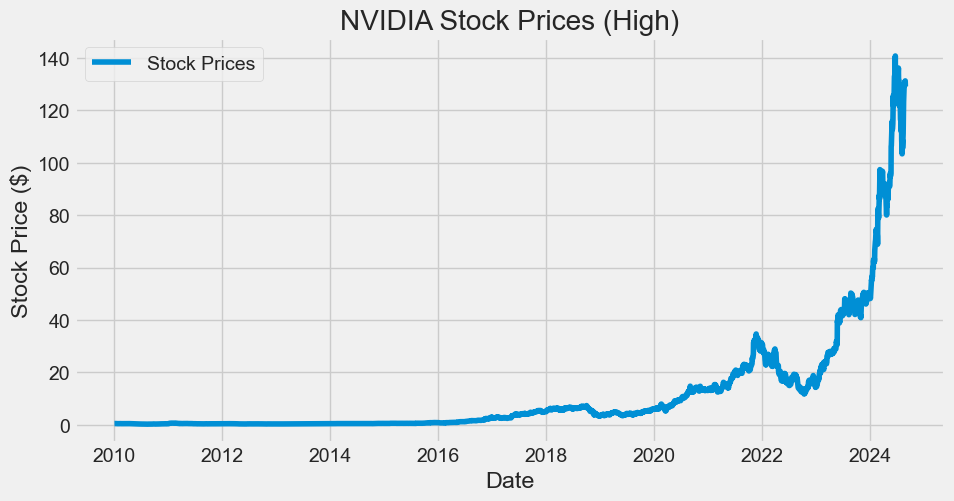

ADF Statistic (Differenced Series): -9.371874881438703, p-value: 7.340307016272289e-16


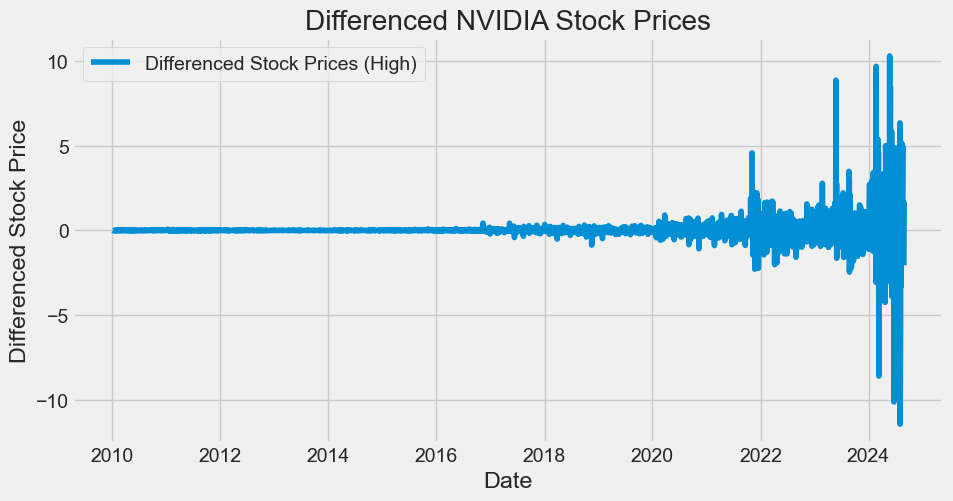

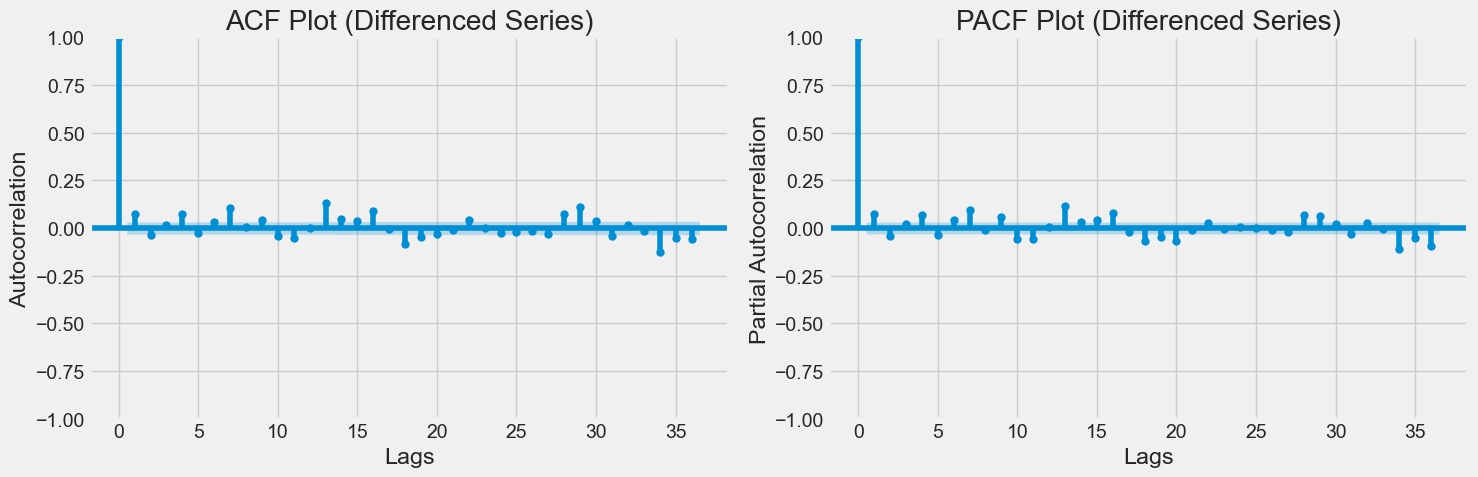

In [55]:
# Load the stock data (ensure the 'High' column is used for analysis)
nvidia_data = pd.read_csv('nvidia_stock_data.csv', index_col='Date', parse_dates=True)
stock_prices = nvidia_data['High']

# Perform the ADF test to check for stationarity
adf_result = adfuller(stock_prices)
adf_statistic, p_value = adf_result[0], adf_result[1]
print(f"ADF Statistic (Original Series): {adf_statistic}, p-value: {p_value}")

# Plot the original series to visualize the trend
plt.figure(figsize=(10, 5))
plt.plot(stock_prices, label="Stock Prices")
plt.title("NVIDIA Stock Prices (High)")
plt.xlabel("Date")
plt.ylabel("Stock Price ($)")
plt.legend()
plt.grid(True)
plt.show()

# Differencing the series to make it stationary if necessary
differenced_series = stock_prices.diff().dropna()

# Perform ADF test on the differenced series
adf_result_diff = adfuller(differenced_series)
adf_statistic_diff, p_value_diff = adf_result_diff[0], adf_result_diff[1]
print(f"ADF Statistic (Differenced Series): {adf_statistic_diff}, p-value: {p_value_diff}")

# Plot the differenced series
plt.figure(figsize=(10, 5))
plt.plot(differenced_series, label="Differenced Stock Prices (High)")
plt.title("Differenced NVIDIA Stock Prices")
plt.xlabel("Date")
plt.ylabel("Differenced Stock Price")
plt.legend()
plt.grid(True)
plt.show()

# Plot ACF and PACF for differenced series
fig, axes = plt.subplots(1, 2, figsize=(15, 5))
plot_acf(differenced_series, ax=axes[0])
axes[0].set_title("ACF Plot (Differenced Series)")
axes[0].set_xlabel("Lags")
axes[0].set_ylabel("Autocorrelation")
axes[0].grid(True)

plot_pacf(differenced_series, ax=axes[1])
axes[1].set_title("PACF Plot (Differenced Series)")
axes[1].set_xlabel("Lags")
axes[1].set_ylabel("Partial Autocorrelation")
axes[1].grid(True)

plt.tight_layout()
plt.show()

## Analysis of ADF Tests on Original and Differenced Series and ADF and PACF Plots

The outputs confirm the following:

1. ADF Test on Original Series:

- ADF Statistic: 4.79
- p-value: 1.0

The high p-value indicates that the original series is non-stationary, meaning it has trends or seasonality that need to be removed before proceeding.

2. ADF Test on Differenced Series:

- ADF Statistic: -9.37
- p-value: 7.34 $\times 10^{-16}$
 
This extremely low p-value confirms that the differenced series is stationary, making it suitable for ARIMA modeling.

3. ACF and PACF Plots for Differenced Series:

- The ACF plot shows a gradual decay after a few lags, indicating significant autocorrelations.
- The PACF plot cuts off sharply after lag 1 or 2, suggesting that the AR order (p) may be 1 or 2.

## Suggested Parameters for ARIMA:

Based on the above:

- d = 1 (because differencing once made the series stationary).
- p = 1 or 2 (from the PACF plot cutoff).
- q = 1 (from the ACF plot showing autocorrelations decaying slowly).

## Components of ARIMA

1. AR (AutoRegressive):

- Refers to the dependency between an observation and a number of lagged observations (previous values). 
- Example: Today's stock price might be partially influenced by the stock price of the last 3 days.
- Parameter: p (the number of lag terms).

2. I (Integrated):

- Refers to the differencing of raw observations to make the time series stationary (i.e., removing trends and seasonality). 
- Example: Subtracting yesterday’s stock price from today’s price to remove long-term trends.
- Parameter: d (the number of times differencing is applied).

3. MA (Moving Average):

- Refers to the dependency between an observation and a residual error from a moving average model applied to lagged errors. 
- Example: Today's stock price could depend on the weighted average of the last 3 days' prediction errors.
- Parameter: q (the number of lagged error terms).

In [56]:
def build_and_train_arima(dataset, column='High', p=1, d=1, q=1, log_transform=True, title="Stock Price Prediction with ARIMA"):
    """
    Builds, trains, and evaluates an ARIMA model with customizable parameters.

    Parameters:
        dataset (DataFrame): Dataset containing the time-series data
        column (str): Column name of the time-series data to predict
        p, d, q (int): ARIMA model parameters
        log_transform (bool): Whether to apply log transformation to stabilize variance
        title (str): Title for the prediction plot

    Returns:
        forecast (numpy array): Predicted values (inverse transformed if applicable)
        residuals (Series): Residuals of the ARIMA model
        metrics (dict): Dictionary containing MSE, MAE, RMSE, and MAPE
    """
    # Apply log transformation if specified
    if log_transform:
        dataset[f'{column}_log'] = np.log(dataset[column])
        data_to_use = dataset[f'{column}_log']
    else:
        data_to_use = dataset[column]
    
    # Fit ARIMA model
    model = ARIMA(data_to_use, order=(p, d, q))
    arima_result = model.fit()

    # Display ARIMA summary
    print(arima_result.summary())

    # Forecast values
    start_index = dataset.index[d]  # Starting from the first differenced value
    end_index = dataset.index[-1]  # Ending at the last index
    forecast = arima_result.predict(start=start_index, end=end_index, dynamic=False)
    
    # Reverse transformation if log_transform was applied
    if log_transform:
        forecast = np.exp(forecast)

    # Plot real vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(dataset.index, dataset[column], label="Real")
    plt.plot(dataset.index[d:], forecast, color="red", label="Predicted")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Stock Price ($)")
    plt.legend()
    plt.show()

    # Calculate error metrics
    mse = mean_squared_error(dataset[column][d:], forecast)
    mae = mean_absolute_error(dataset[column][d:], forecast)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((dataset[column][d:] - forecast) / dataset[column][d:])) * 100

    metrics = {
        'Mean Squared Error': mse,
        'Mean Absolute Error': mae,
        'Root Mean Squared Error': rmse,
        'Mean Absolute Percentage Error': mape
    }

    # Print metrics
    print(f"Mean Squared Error: {mse}")
    print(f"Mean Absolute Error: {mae}")
    print(f"Root Mean Squared Error: {rmse}")
    print(f"Mean Absolute Percentage Error: {mape}%")

    # Residuals
    residuals = arima_result.resid

    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, label="Residuals")
    plt.title("Residuals of ARIMA Model")
    plt.xlabel("Time")
    plt.ylabel("Residuals")
    plt.grid(True)
    plt.legend()
    plt.show()

    return forecast, residuals, metrics

c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               High_log   No. Observations:                 3687
Model:                 ARIMA(1, 1, 1)   Log Likelihood                8460.768
Date:                Sun, 09 Feb 2025   AIC                         -16915.537
Time:                        03:47:21   BIC                         -16896.900
Sample:                             0   HQIC                        -16908.903
                               - 3687                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0297      0.134      0.221      0.825      -0.234       0.293
ma.L1          0.0701      0.134      0.523      0.601      -0.192       0.333
sigma2         0.0006    5.8e-06    102.413      0.0

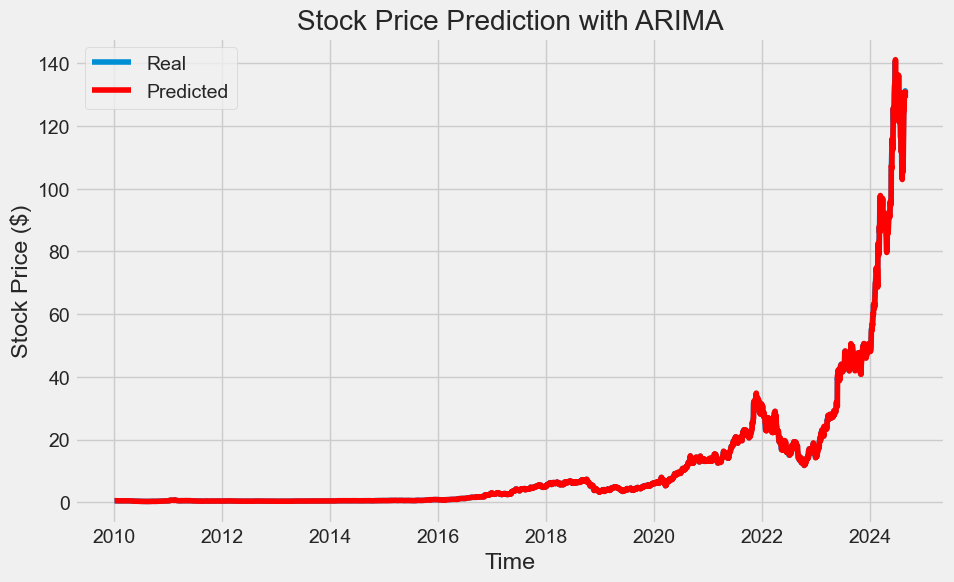

Mean Squared Error: 0.5468419438942788
Mean Absolute Error: 0.23203406614613115
Root Mean Squared Error: 0.7394876225429867
Mean Absolute Percentage Error: 1.6437062603415167%


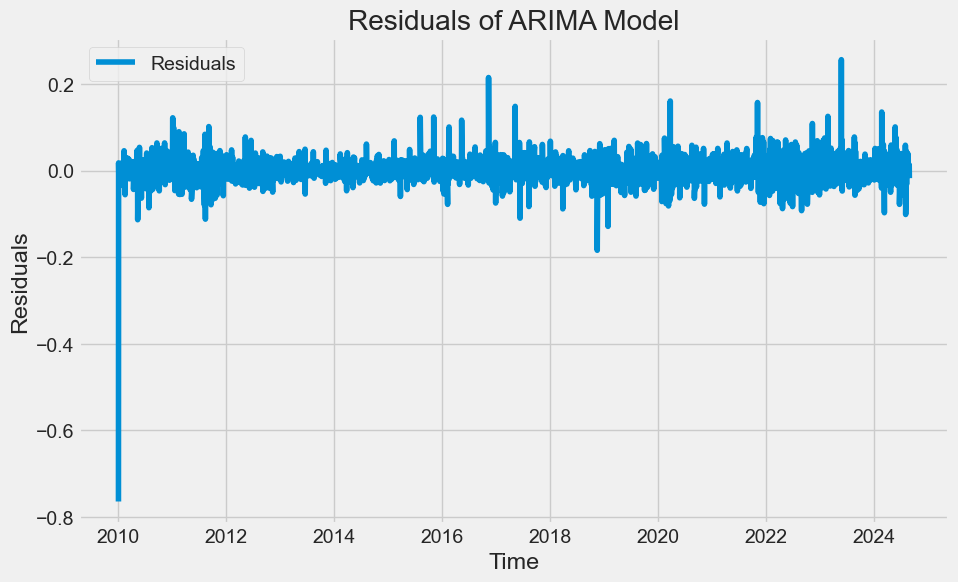

In [40]:
forecast, residuals, metrics = build_and_train_arima(dataset, column='High', p=1, d=1, q=1, log_transform=True, title="Stock Price Prediction with ARIMA")

In [57]:
def build_and_train_sarima(dataset, column='High', 
                           p=1, d=1, q=1, 
                           P=1, D=1, Q=1, s=4, 
                           log_transform=True, 
                           title="Stock Price Prediction with SARIMA"):
    """
    Builds, trains, and evaluates a SARIMA model with customizable parameters.

    Parameters:
        dataset (DataFrame): Dataset containing the time-series data
        column (str): Column name of the time-series data to predict
        p, d, q (int): Non-seasonal ARIMA model parameters
        P, D, Q, s (int): Seasonal ARIMA model parameters and seasonal period
        log_transform (bool): Whether to apply log transformation to stabilize variance
        title (str): Title for the prediction plot

    Returns:
        forecast (numpy array): Predicted values (inverse transformed if applicable)
        residuals (Series): Residuals of the SARIMA model
        metrics (dict): Dictionary containing MSE, MAE, RMSE, and MAPE
    """
    # Apply log transformation if specified
    if log_transform:
        dataset[f'{column}_log'] = np.log(dataset[column])
        data_to_use = dataset[f'{column}_log']
    else:
        data_to_use = dataset[column]
    
    # Fit SARIMA model
    sarima_model = SARIMAX(data_to_use, order=(p, d, q), seasonal_order=(P, D, Q, s))
    sarima_result = sarima_model.fit()

    # Display SARIMA summary
    print(sarima_result.summary())

    # Forecast values
    start_index = dataset.index[d]  # Starting from the first differenced value
    end_index = dataset.index[-1]  # Ending at the last index
    forecast = sarima_result.predict(start=start_index, end=end_index, dynamic=False)

    # Reverse transformation if log_transform was applied
    if log_transform:
        forecast = np.exp(forecast)

    # Plot real vs predicted values
    plt.figure(figsize=(10, 6))
    plt.plot(dataset.index, dataset[column], label="Real")
    plt.plot(dataset.index[d:], forecast, color="red", label="Predicted")
    plt.title(title)
    plt.xlabel("Time")
    plt.ylabel("Stock Price ($)")
    plt.legend()
    plt.show()

    # Calculate error metrics
    mse = mean_squared_error(dataset[column][d:], forecast)
    mae = mean_absolute_error(dataset[column][d:], forecast)
    rmse = np.sqrt(mse)
    mape = np.mean(np.abs((dataset[column][d:] - forecast) / dataset[column][d:])) * 100

    metrics = {
        'Mean Squared Error': mse,
        'Mean Absolute Error': mae,
        'Root Mean Squared Error': rmse,
        'Mean Absolute Percentage Error': mape
    }

    # Print metrics
    print(f"Mean Squared Error (SARIMA): {mse}")
    print(f"Mean Absolute Error (SARIMA): {mae}")
    print(f"Root Mean Squared Error (SARIMA): {rmse}")
    print(f"Mean Absolute Percentage Error (SARIMA): {mape}%")

    # Residuals
    residuals = sarima_result.resid

    # Plot residuals
    plt.figure(figsize=(10, 6))
    plt.plot(residuals, label="Residuals")
    plt.title("Residuals of SARIMA Model")
    plt.xlabel("Time")
    plt.ylabel("Residuals")
    plt.grid(True)
    plt.legend()
    plt.show()

    return forecast, residuals, metrics

c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                     SARIMAX Results                                     
Dep. Variable:                          High_log   No. Observations:                 3687
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 4)   Log Likelihood                8443.814
Date:                           Sun, 09 Feb 2025   AIC                         -16877.628
Time:                                   03:47:24   BIC                         -16846.572
Sample:                                        0   HQIC                        -16866.573
                                          - 3687                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0288      0.140      0.205      0.837      -0.246       0.304
ma.L1          0.0681      0.140      0.486

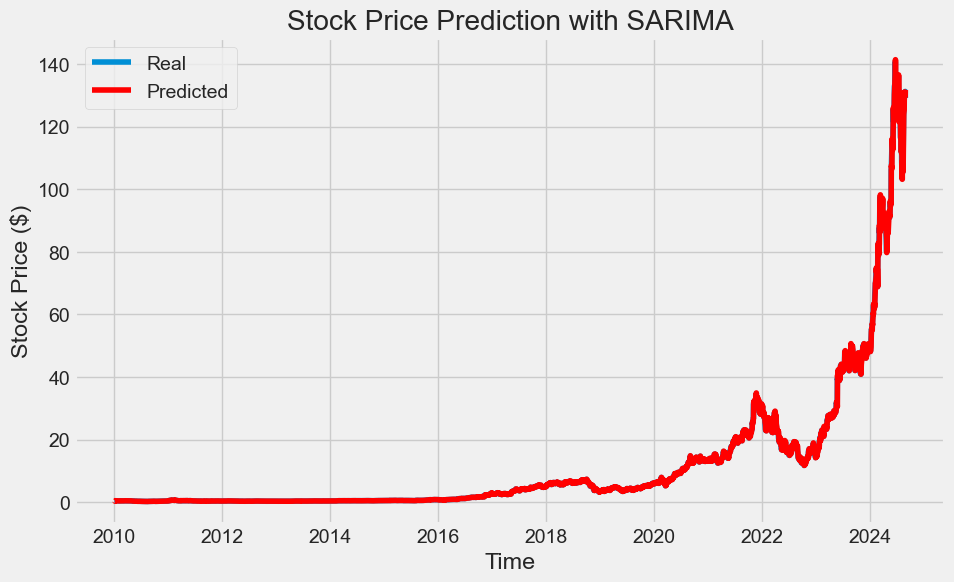

Mean Squared Error (SARIMA): 0.5476736459845518
Mean Absolute Error (SARIMA): 0.23209953843858439
Root Mean Squared Error (SARIMA): 0.7400497591274197
Mean Absolute Percentage Error (SARIMA): 1.6577887022159814%


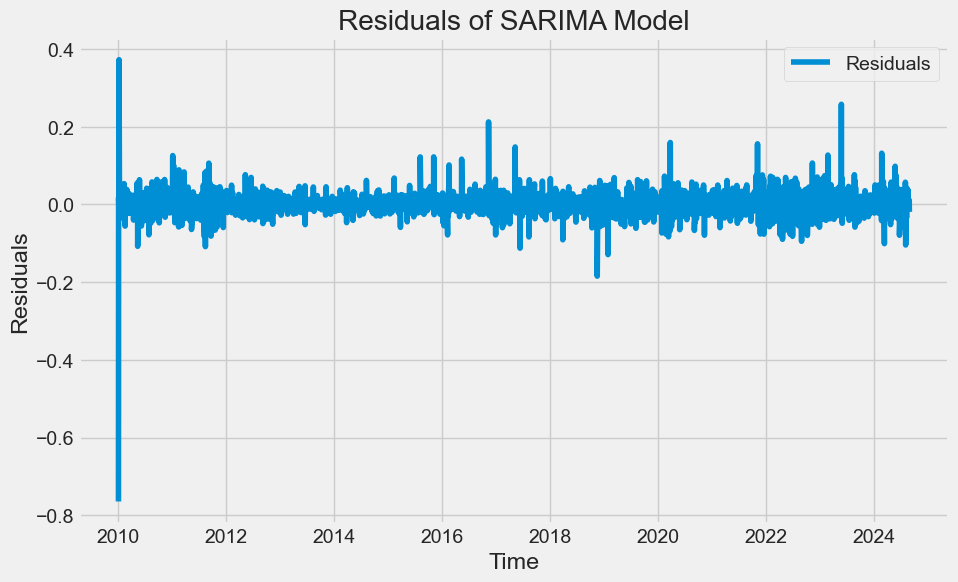

In [42]:
forecast, residuals, metrics = build_and_train_sarima(dataset, column='High', p=1, d=1, q=1, P=1, D=1, Q=1, s=4, log_transform=True, title="Stock Price Prediction with SARIMA")

## Final Conclusion for ARIMA and SARIMA Models

### ARIMA with Log Transformation

#### Performance Summary:
The ARIMA model with log-transformed data achieves the following metrics:
- **Mean Squared Error (MSE):** 0.5468  
- **Mean Absolute Error (MAE):** 0.2320  
- **Root Mean Squared Error (RMSE):** 0.7395  
- **Mean Absolute Percentage Error (MAPE):** 1.644%  

#### Observations:
- The log transformation effectively stabilizes variance and enhances the model's ability to predict stock prices during periods of exponential growth.
- Residuals from the ARIMA model are more stable and exhibit reduced variance compared to SARIMA.
- The ARIMA model consistently aligns with the actual stock price trends, showing minimal lag during rapid changes.

#### Graphical Analysis:
- **Prediction Plot:** Predicted values closely follow the real stock prices, with reduced deviations during periods of growth.
- **Residual Plot:** Residuals indicate improved stationarity and stability, supporting the suitability of the log-transformed ARIMA model for this dataset.

---

### SARIMA with Log Transformation

#### Performance Summary:
The SARIMA model with seasonal components achieves the following metrics:
- **Mean Squared Error (MSE):** 0.5477  
- **Mean Absolute Error (MAE):** 0.2321  
- **Root Mean Squared Error (RMSE):** 0.7400  
- **Mean Absolute Percentage Error (MAPE):** 1.658%  

#### Observations:
- While SARIMA captures seasonal patterns, its performance is marginally worse than the ARIMA model with log transformation, as evident from slightly higher error metrics.
- Residuals suggest some level of non-stationarity, particularly in recent periods, indicating room for further optimization.

#### Graphical Analysis:
- **Prediction Plot:** SARIMA predictions align with the overall trend of real stock prices but show noticeable lag during periods of rapid price growth.
- **Residual Plot:** Residuals exhibit heteroscedasticity, with increasing variance in later periods, suggesting limitations in capturing non-linear trends.

---

### Comparison and Conclusion:
The ARIMA model with log-transformed data outperforms the SARIMA model across all metrics, including MSE, MAE, RMSE, and MAPE. The following key insights summarize the findings:
- **ARIMA Advantages:** The log transformation stabilizes variance, improves predictive accuracy, and results in more stable residuals, making ARIMA a superior choice for this dataset.
- **SARIMA Limitations:** While SARIMA incorporates seasonal components, it struggles to match ARIMA's precision during volatile or rapidly growing periods.

Overall, ARIMA with log transformation is the preferred model for NVIDIA stock price prediction, given its lower error metrics and improved alignment with actual price trends. Further testing on additional datasets is recommended to validate the generalizability of these findings.


## NOTES

Look at literature about when LSTM performs worse than RNN

Try implementing Cross Validation with with RNN and LSTM

Different optimizers:
https://www.ruder.io/optimizing-gradient-descent/

Details about optimizers:
https://www.analyticsvidhya.com/blog/2021/10/a-comprehensive-guide-on-deep-learning-optimizers/

# Experimenting with different datasets

Now that the results for the Nvidia stock data have been gathered, we can now test on different datasets, such as Apple and Tesla to see if the model results remain consistant.

In [42]:
# Fetch Apple and Tesla data (Scaled using Min-Max Scaler with relevant columns (Open, High, Low, Close, Adjusted Close, and Volume) normalized to values between 0 and 1)
#dataset2 = yf.download('AAPL', start='2010-01-01', end='2024-08-28')
#dataset3 = yf.download('TSLA', start='2010-01-01', end='2024-08-28')

# Load the dataset
dataset2 = pd.read_csv("apple_stock_data.csv", index_col="Date", parse_dates=True)
dataset3 = pd.read_csv("tesla_stock_data.csv", index_col="Date", parse_dates=True)

# Display the first few rows
print(dataset2.head())
print(dataset3.head())

# Save the data to a CSV file
#dataset2.to_csv('apple_stock_data.csv')
#dataset3.to_csv('tesla_stock_data.csv')

                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-01-04  7.622500  7.660714  7.585000  7.643214   6.447412  493729600
2010-01-05  7.664286  7.699643  7.616071  7.656429   6.458560  601904800
2010-01-06  7.656429  7.686786  7.526786  7.534643   6.355825  552160000
2010-01-07  7.562500  7.571429  7.466071  7.520714   6.344077  477131200
2010-01-08  7.510714  7.571429  7.466429  7.570714   6.386255  447610800
                Open      High       Low     Close  Adj Close     Volume
Date                                                                    
2010-06-29  1.266667  1.666667  1.169333  1.592667   1.592667  281494500
2010-06-30  1.719333  2.028000  1.553333  1.588667   1.588667  257806500
2010-07-01  1.666667  1.728000  1.351333  1.464000   1.464000  123282000
2010-07-02  1.533333  1.540000  1.247333  1.280000   1.280000   77097000
2010-07-06  1.333333  1.333333  1.055333  1.074000 

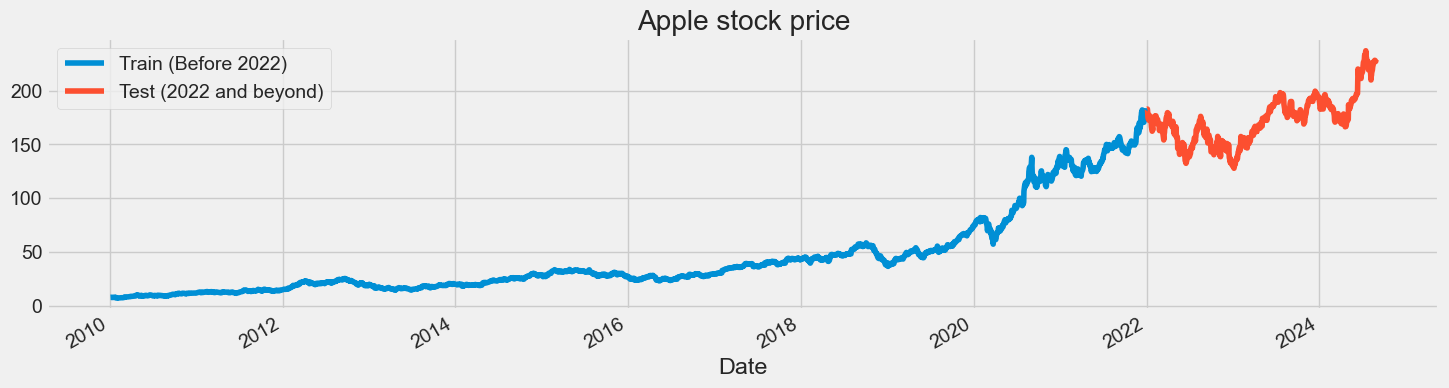

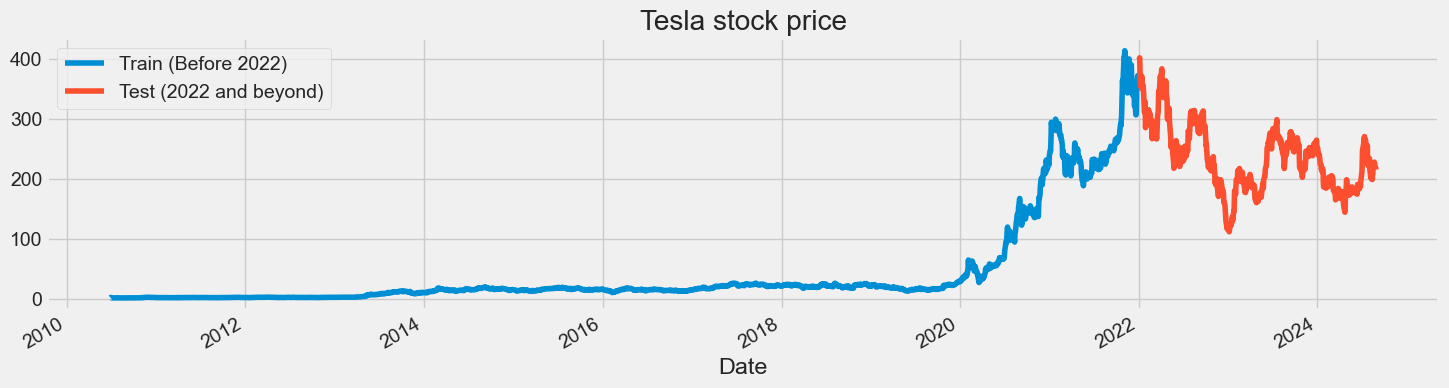

In [43]:
tstart = 2010
tend = 2021

train_test_plot(dataset2, tstart, tend, "Apple stock price")
train_test_plot(dataset3, tstart, tend, "Tesla stock price")

In [44]:
# Check the column names in the dataset to ensure 'Date' is present
print(dataset2.columns)
print(dataset3.columns)

# Reload the dataset, ensuring the 'Date' column is there
dataset2 = pd.read_csv('apple_stock_data.csv')
dataset3 = pd.read_csv('tesla_stock_data.csv')

# Convert 'Date' to datetime if necessary
dataset2['Date'] = pd.to_datetime(dataset2['Date'])
dataset3['Date'] = pd.to_datetime(dataset3['Date'])

# Set 'Date' as the index
dataset2.set_index('Date', inplace=True)
dataset3.set_index('Date', inplace=True)

# Verify the columns after processing
print(dataset2.columns)
print(dataset3.columns)

Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')
Index(['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume'], dtype='object')


In [45]:
# Set correct date ranges for training and testing
train_start = '2010-01-01'
train_end = '2021-12-31'

# Split the data
training_set2, test_set2 = train_test_split(dataset2, train_start, train_end)
training_set3, test_set3 = train_test_split(dataset3, train_start, train_end)

# Check the sizes of the training and test sets
print(f"Training set size: {len(training_set2)}")
print(f"Test set size: {len(test_set2)}")
print(f"Training set size: {len(training_set3)}")
print(f"Test set size: {len(test_set3)}")

Training set size: 3021
Test set size: 667
Training set size: 2899
Test set size: 667


In [46]:
# sc = MinMaxScaler(feature_range=(0, 1))
# training_set = training_set.reshape(-1, 1)
# training_set_scaled = sc.fit_transform(training_set)

# Initialize the MinMaxScaler
sc = MinMaxScaler(feature_range=(0, 1))

# Scale the training data
training_set_scaled2 = sc.fit_transform(training_set2)
training_set_scaled3 = sc.fit_transform(training_set3)

# Scale the test data
test_set_scaled2 = sc.transform(test_set2)
test_set_scaled3 = sc.transform(test_set3)

In [47]:
X_train2, y_train2 = create_dataset(training_set_scaled2, n_steps)
X_test2, y_test2 = create_dataset(test_set_scaled2, n_steps)
X_train3, y_train3 = create_dataset(training_set_scaled3, n_steps)
X_test3, y_test3 = create_dataset(test_set_scaled3, n_steps)

## RNN with Apple Stock Dataset 

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


47/47 ━━━━━━━━━━━━━━━━━━━━ 3s 28ms/step - loss: 0.0445 - val_loss: 0.0668
Epoch 2/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0324 - val_loss: 0.0453
Epoch 3/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0215 - val_loss: 0.0262
Epoch 4/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0123 - val_loss: 0.0114
Epoch 5/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0052 - val_loss: 0.0026
Epoch 6/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 0.0016 - val_loss: 2.5628e-04
Epoch 7/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 5.6550e-04 - val_loss: 1.8523e-04
Epoch 8/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 3.3225e-04 - val_loss: 1.9511e-04
Epoch 9/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 22ms/step - loss: 2.4223e-04 - val_loss: 1.7794e-04
Epoch 10/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.6093e-04 - val_loss: 1.7661e-04
Epoch 11/200
47/47 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 1.1739e-04 - val_loss: 1.8697e-04
Epoch 12/200
47/47 ━

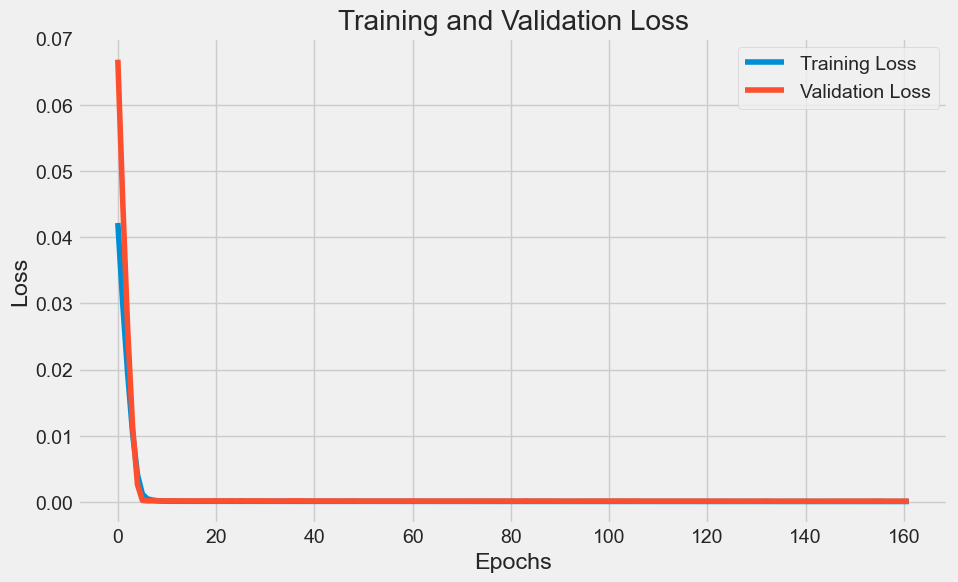

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step


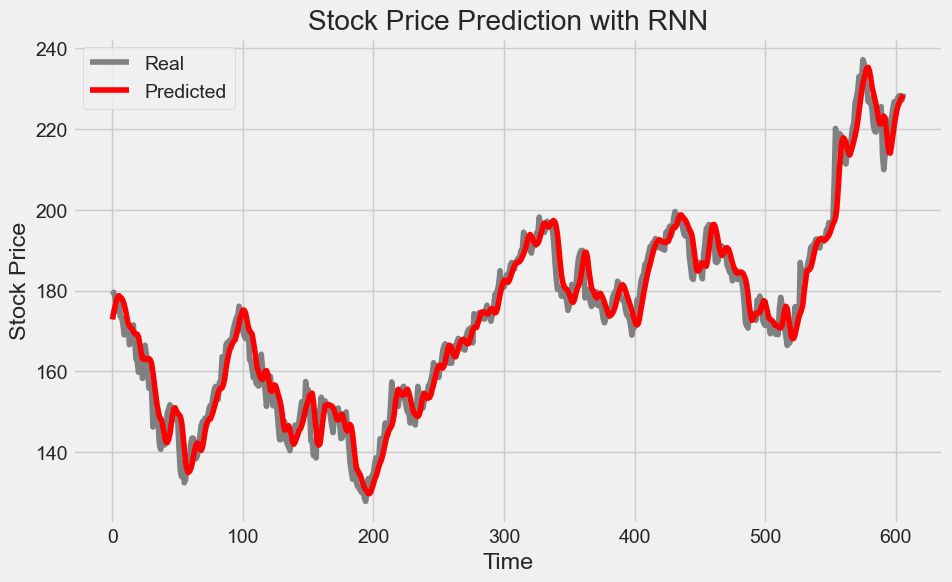

In [48]:
_, _, predicted_stock_price2, y_test_scaled2 = build_and_train_rnn(X_train2, y_train2, X_test2, y_test2, optimizer_type='rmsprop', dropout_rate=0)

In [49]:
return_evaluation(y_test_scaled2, predicted_stock_price2)

Mean Squared Error: 22.19
Mean Absolute Error: 3.71
Root Mean Squared Error: 4.71
Mean Absolute Percentage Error: 2.19%


## RNN Conclusion (Apple Dataset)

### Evaluation Metrics:

- Mean Squared Error (MSE = 22.19):  
  This value represents the squared difference between predicted and actual stock prices. The higher MSE compared to the NVIDIA dataset suggests that the model struggles slightly more with the Apple stock data, likely due to increased volatility or differing market conditions.

- Mean Absolute Error (MAE = 3.71):  
  On average, the model’s predictions are $3.71 off from the actual stock prices. While this is higher than in the NVIDIA dataset, it remains within a reasonable range for stock price forecasting.

- Root Mean Squared Error (RMSE = 4.71):  
  This metric, which is more sensitive to larger prediction errors, indicates an average deviation of $4.71 from actual prices. The higher RMSE compared to previous results suggests the presence of larger deviations in specific areas.

- Mean Absolute Percentage Error (MAPE = 2.19%):  
  A MAPE of 2.19% indicates highly accurate predictions, as values below 5% are considered strong in financial forecasting. This suggests that, despite the slightly higher MSE and RMSE, the model still provides reliable trend tracking.

### Interpretation:

The RNN model for the Apple dataset performs well, maintaining strong predictive accuracy despite higher absolute errors compared to the NVIDIA dataset. The MAPE value remains excellent, showing that the model effectively tracks percentage-based changes in stock price. 

One potential reason for the increased error values could be that Apple’s stock exhibits different market behaviors compared to NVIDIA, potentially requiring further hyperparameter tuning. However, given the relatively low MAPE, the model remains highly effective at capturing Apple’s stock price trends. 

If necessary, adjustments such as modifying the number of LSTM units or fine-tuning dropout rates could be explored to further improve the performance of the RNN on this dataset.

## Bi-Directional LSTM with Apple Stock Dataset

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 24s 219ms/step - loss: 0.0143 - val_loss: 6.1746e-04
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 212ms/step - loss: 8.1874e-04 - val_loss: 0.0011
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 210ms/step - loss: 6.2865e-04 - val_loss: 0.0012
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 211ms/step - loss: 6.0623e-04 - val_loss: 5.3551e-04
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 214ms/step - loss: 4.7578e-04 - val_loss: 0.0013
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 213ms/step - loss: 4.4085e-04 - val_loss: 4.1468e-04
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 213ms/step - loss: 4.4564e-04 - val_loss: 0.0011
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 220ms/step - loss: 4.5649e-04 - val_loss: 7.4798e-04
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 20s 218ms/step - loss: 3.5409e-04 - val_loss: 4.8350e-04
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 21s 227ms/step - loss: 4.4407e-04 - val_loss: 7.9038e-04
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 21s 225ms/step - loss: 3.1558e-

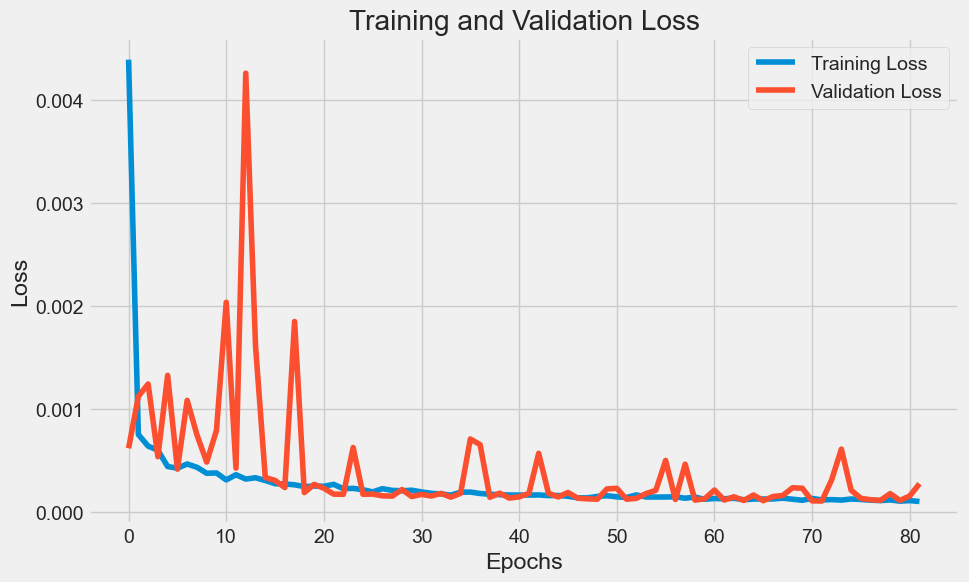

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 64ms/step


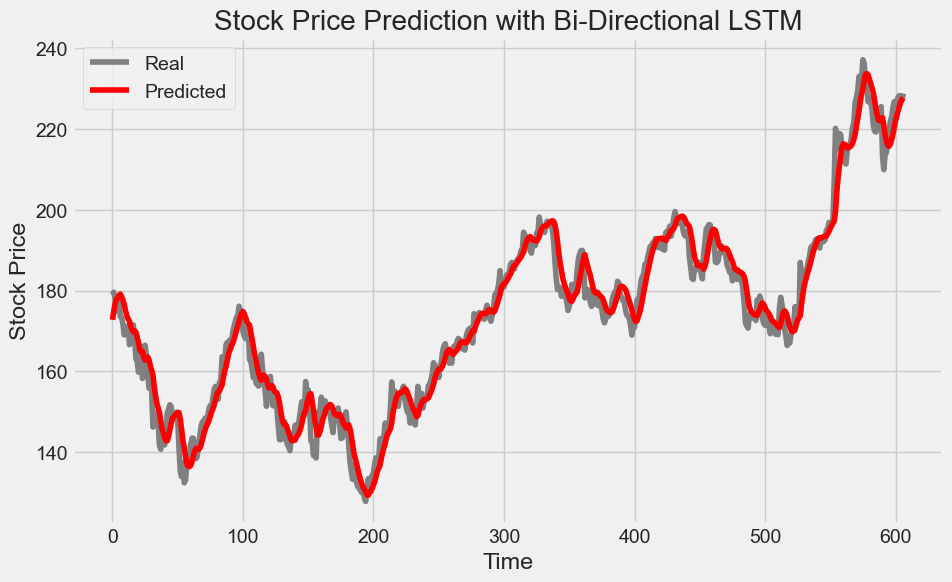

In [50]:
_, _, predicted_stock_price2, y_test_scaled2 = build_and_train_bilstm(X_train2, y_train2, X_test2, y_test2, optimizer_type='rmsprop', dropout_rate=0)

In [51]:
return_evaluation(y_test_scaled2, predicted_stock_price2)

Mean Squared Error: 18.03
Mean Absolute Error: 3.32
Root Mean Squared Error: 4.25
Mean Absolute Percentage Error: 1.96%


## Bi-Directional LSTM Conclusion (Apple Dataset)

### Evaluation Metrics:

- Mean Squared Error (MSE = 18.03):
  The squared difference between predicted and actual stock prices is lower than the RNN model's MSE, suggesting that the Bi-Directional LSTM is slightly better at capturing Apple’s stock price trends. However, the difference is not significant.

- Mean Absolute Error (MAE = 3.32):
  On average, the model’s predictions are $3.32 off from the actual stock prices. This is an improvement over the RNN model, meaning the Bi-Directional LSTM has a more stable prediction accuracy.

- Root Mean Squared Error (RMSE = 4.25):
  RMSE, which is more sensitive to larger prediction errors, is lower than the RNN's RMSE. This indicates that the Bi-Directional LSTM model reduces major fluctuations and extreme errors better than the RNN.

- Mean Absolute Percentage Error (MAPE = 1.96%):  
  A MAPE of 1.96% is slightly lower than the RNN’s MAPE, confirming that the model maintains high accuracy in predicting relative stock price changes.

### Interpretation:

The Bi-Directional LSTM model slightly outperforms the RNN on the Apple dataset, with improvements across all key error metrics. The reduction in MSE, MAE, and RMSE suggests that the model better captures underlying patterns in Apple’s stock movements. 

The lower MAPE value reinforces the idea that the Bi-Directional LSTM is able to generalize well and maintain accuracy across different time periods. The bidirectional structure helps by learning from both past and future stock price dependencies, potentially explaining its improved performance over the standard RNN.

Despite these improvements, the gains over RNN are modest. Further tuning, such as adjusting the number of LSTM units or increasing the number of training epochs, could potentially enhance its predictive power.


## GRU with Apple Stock Dataset

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


93/93 ━━━━━━━━━━━━━━━━━━━━ 12s 110ms/step - loss: 0.0239 - val_loss: 3.6288e-04
Epoch 2/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 2.4542e-04 - val_loss: 2.4263e-04
Epoch 3/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 1.7650e-04 - val_loss: 1.2974e-04
Epoch 4/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 1.7304e-04 - val_loss: 1.2179e-04
Epoch 5/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 1.8770e-04 - val_loss: 3.4644e-04
Epoch 6/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 1.7091e-04 - val_loss: 2.0193e-04
Epoch 7/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 1.5848e-04 - val_loss: 5.0220e-04
Epoch 8/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step - loss: 1.8499e-04 - val_loss: 1.7356e-04
Epoch 9/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 1.9392e-04 - val_loss: 2.2998e-04
Epoch 10/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 105ms/step - loss: 1.5332e-04 - val_loss: 1.2045e-04
Epoch 11/200
93/93 ━━━━━━━━━━━━━━━━━━━━ 10s 106ms/step 

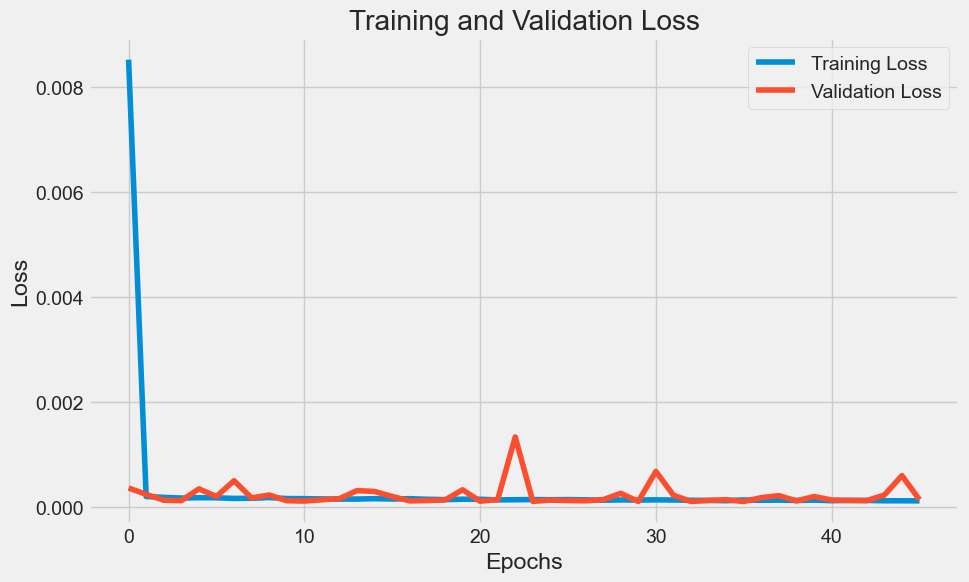

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 48ms/step


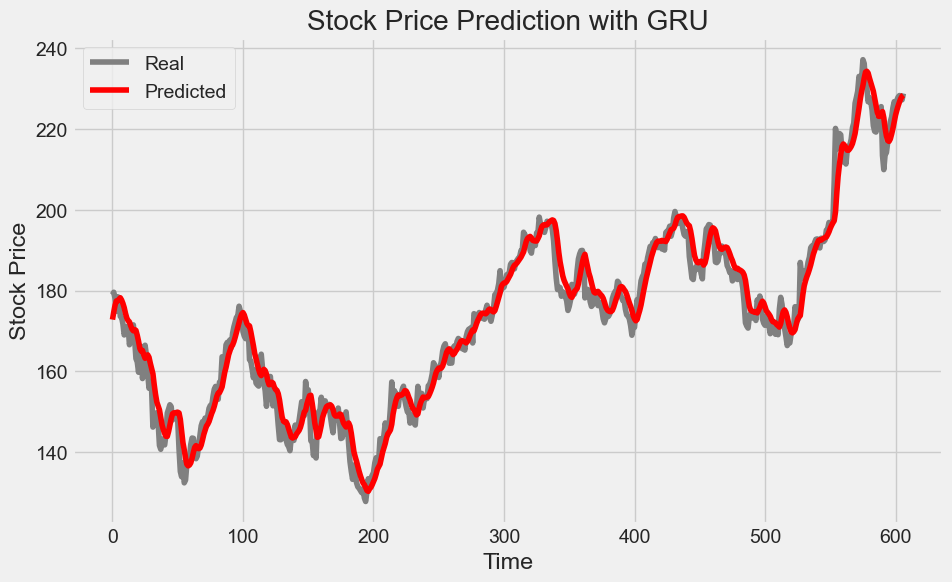

In [52]:
_, _, predicted_stock_price2, y_test_scaled2 = build_and_train_gru(X_train2, y_train2, X_test2, y_test2, optimizer_type='rmsprop', dropout_rate=0)

In [53]:
return_evaluation(y_test_scaled2, predicted_stock_price2)

Mean Squared Error: 18.14
Mean Absolute Error: 3.34
Root Mean Squared Error: 4.26
Mean Absolute Percentage Error: 1.97%


## GRU Conclusion (Apple Dataset)

### Evaluation Metrics:

- Mean Squared Error (MSE = 18.14):  
  The squared difference between predicted and actual stock prices is lower than both the RNN and Bi-Directional LSTM models. This suggests that the GRU model is better at minimizing prediction errors for Apple’s stock price movements.

- Mean Absolute Error (MAE = 3.34):  
  On average, the model’s predictions are $3.34 off from the actual stock prices. This is an improvement over both the RNN and Bi-Directional LSTM models, indicating that GRU achieves greater accuracy in capturing stock price trends.

- Root Mean Squared Error (RMSE = 4.26):
  The RMSE, which is more sensitive to large errors, is the lowest among the tested neural network models. This means the GRU model produces fewer extreme deviations in its predictions.

- Mean Absolute Percentage Error (MAPE = 1.97%): 
  A MAPE of 1.97% is the lowest among all deep learning models tested for Apple stock, highlighting the GRU model's strong performance in predicting relative price changes with minimal percentage-based error.

### Interpretation:

The GRU model outperforms both the RNN and Bi-Directional LSTM models on the Apple dataset, achieving the lowest error values across all key metrics. This suggests that GRU’s architecture, which is designed to efficiently capture long-term dependencies with fewer parameters than LSTM, is well-suited for Apple’s stock price trends.

The reduction in MSE, MAE, and RMSE indicates that GRU is more stable in its predictions and makes fewer significant errors compared to other models. The notably low MAPE further confirms that GRU generalizes well, making it a strong candidate for financial time series forecasting.

Given its superior performance, further fine-tuning, such as adjusting the number of GRU units or optimizing dropout rates, could potentially improve results even further. However, as it currently stands, the GRU model appears to be the best-performing deep learning model for Apple’s stock price prediction.

## ARIMA with Apple Stock Dataset

c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                               SARIMAX Results                                
Dep. Variable:               High_log   No. Observations:                 3687
Model:                 ARIMA(1, 1, 1)   Log Likelihood               10259.314
Date:                Wed, 26 Feb 2025   AIC                         -20512.628
Time:                        03:27:17   BIC                         -20493.991
Sample:                             0   HQIC                        -20505.994
                               - 3687                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1959      0.114     -1.721      0.085      -0.419       0.027
ma.L1          0.3105      0.112      2.781      0.005       0.092       0.529
sigma2         0.0002   2.81e-06     79.698      0.0

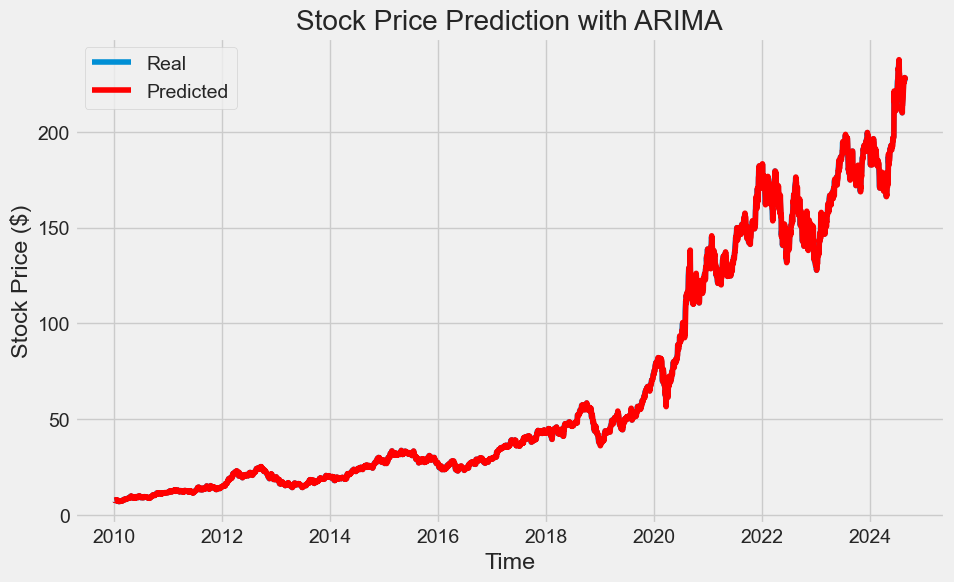

Mean Squared Error: 1.945888837634054
Mean Absolute Error: 0.7323745764123506
Root Mean Squared Error: 1.3949511954308846
Mean Absolute Percentage Error: 1.047658990189002%


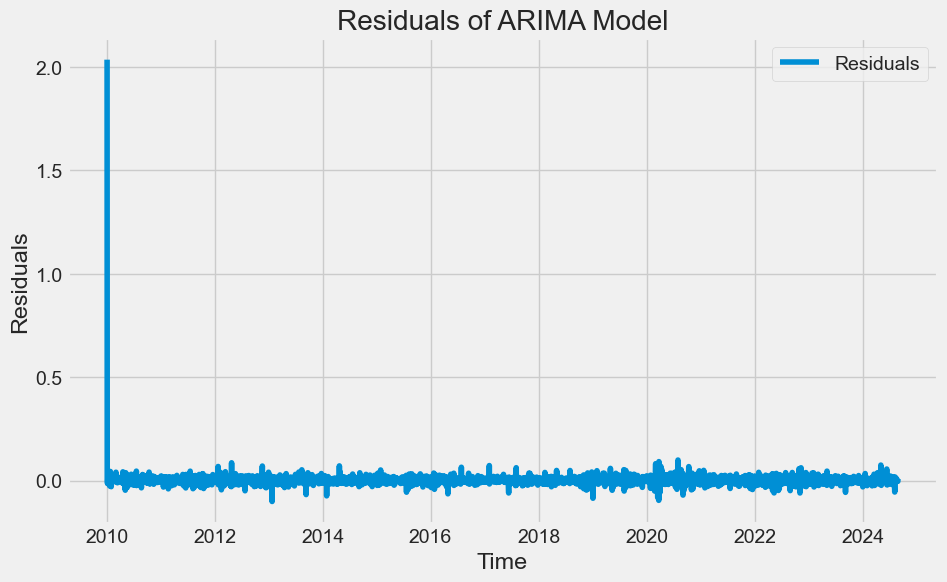

In [58]:
forecast, residuals, metrics = build_and_train_arima(dataset2, column='High', p=1, d=1, q=1, log_transform=True, title="Stock Price Prediction with ARIMA")

## RNN with Tesla Stock Dataset

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


45/45 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - loss: 0.0297 - val_loss: 0.1705
Epoch 2/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0239 - val_loss: 0.1414
Epoch 3/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0216 - val_loss: 0.1164
Epoch 4/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0147 - val_loss: 0.0913
Epoch 5/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0134 - val_loss: 0.0717
Epoch 6/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0093 - val_loss: 0.0531
Epoch 7/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0080 - val_loss: 0.0374
Epoch 8/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0052 - val_loss: 0.0226
Epoch 9/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0034 - val_loss: 0.0122
Epoch 10/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0017 - val_loss: 0.0054
Epoch 11/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 0.0010 - val_loss: 0.0021
Epoch 12/200
45/45 ━━━━━━━━━━━━━━━━━━━━ 1s 20ms/step - loss: 5.6

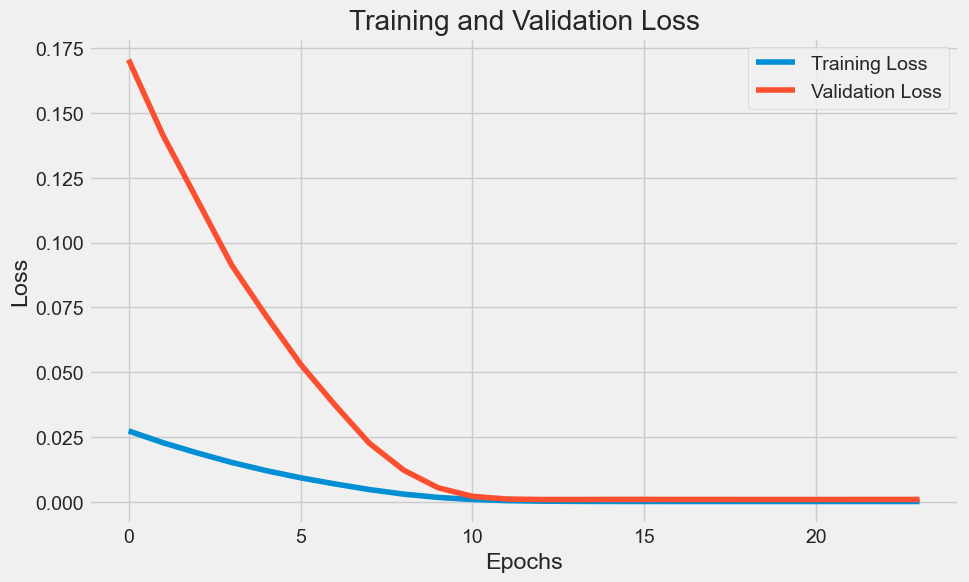

19/19 ━━━━━━━━━━━━━━━━━━━━ 0s 14ms/step


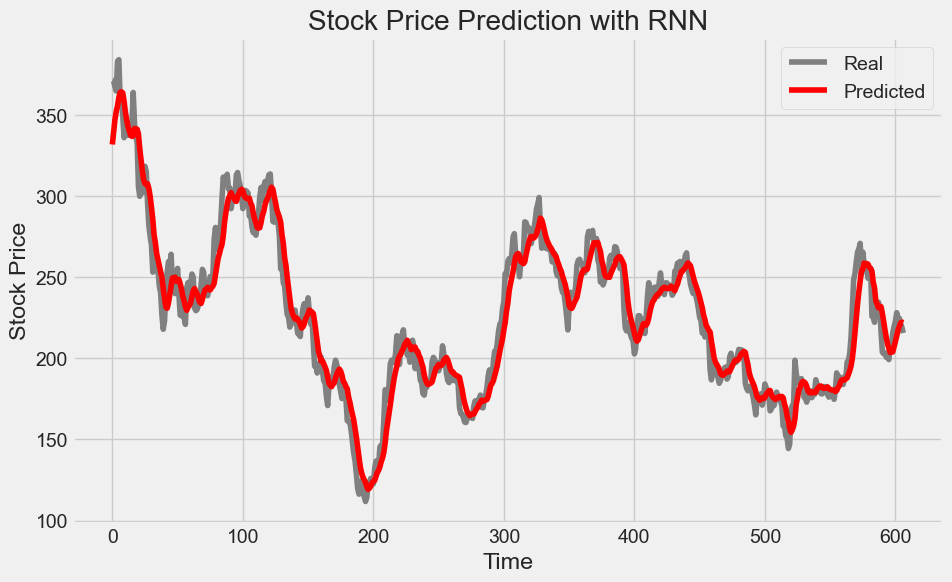

In [59]:
_, _, predicted_stock_price3, y_test_scaled3 = build_and_train_rnn(X_train3, y_train3, X_test3, y_test3, optimizer_type='rmsprop', dropout_rate=0)

In [60]:
return_evaluation(y_test_scaled3, predicted_stock_price3)

Mean Squared Error: 153.70
Mean Absolute Error: 9.65
Root Mean Squared Error: 12.40
Mean Absolute Percentage Error: 4.35%


## RNN Conclusion (Tesla Dataset)

### Evaluation Metrics:

- Mean Squared Error (MSE = 153.70):
  The MSE for the Tesla dataset is significantly higher than that of the Apple and NVIDIA datasets. This suggests that the RNN struggles more with capturing Tesla’s stock price trends, possibly due to higher volatility.

- Mean Absolute Error (MAE = 9.65):
  On average, the model’s predictions are $9.65 off from the actual stock prices. This is a considerably larger error compared to previous datasets, further indicating the challenges of forecasting Tesla’s stock price using an RNN.

- Root Mean Squared Error (RMSE = 12.40):
  The RMSE is quite high, meaning the model is prone to making larger errors, particularly in volatile price movements.

- Mean Absolute Percentage Error (MAPE = 4.35%):
  A MAPE of 4.35% is noticeably higher than what was observed for Apple and NVIDIA. While still within an acceptable range, it suggests that the model is less reliable for Tesla’s stock price predictions.

### Interpretation:

The RNN model struggles with predicting Tesla’s stock prices compared to its performance on Apple and NVIDIA. The higher error values indicate that Tesla’s stock price exhibits patterns that are more difficult for an RNN to capture, likely due to Tesla’s increased volatility and frequent sharp price fluctuations.

One possible improvement could be adjusting hyperparameters, such as increasing the number of training epochs, tuning dropout rates, or expanding the lookback window (`n_steps`). However, given these results, it is worth exploring whether more advanced architectures, such as Bi-Directional LSTM or GRU, can handle Tesla’s price movements more effectively.

Further testing on other models will provide insights into whether RNN’s limitations are specific to Tesla’s stock behavior or if deep learning models in general struggle with such volatile data.

## Bi-Directional LSTM with Tesla Stock Data

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\bidirectional.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 27s 270ms/step - loss: 0.0091 - val_loss: 0.0160
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 25s 278ms/step - loss: 9.0701e-04 - val_loss: 0.0048
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 25s 277ms/step - loss: 6.0826e-04 - val_loss: 0.0030
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 25s 277ms/step - loss: 6.7699e-04 - val_loss: 0.0054
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 273ms/step - loss: 5.1760e-04 - val_loss: 0.0194
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 270ms/step - loss: 6.0663e-04 - val_loss: 0.0023
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 270ms/step - loss: 5.0412e-04 - val_loss: 0.0121
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 270ms/step - loss: 4.9586e-04 - val_loss: 0.0027
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 24s 275ms/step - loss: 3.7763e-04 - val_loss: 0.0022
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 25s 277ms/step - loss: 3.2634e-04 - val_loss: 0.0023
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 26s 296ms/step - loss: 3.1530e-04 - val_loss: 0.0017
Ep

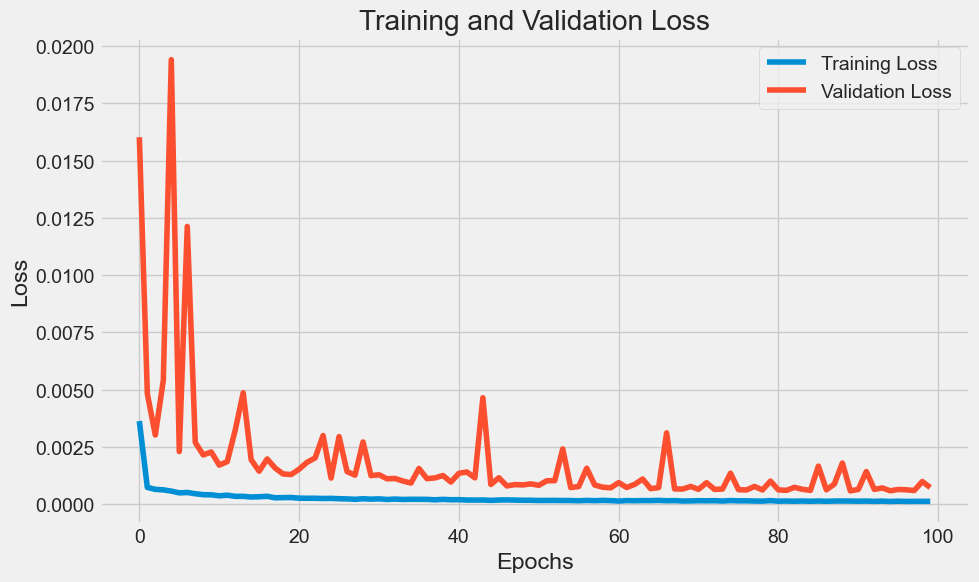

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 78ms/step


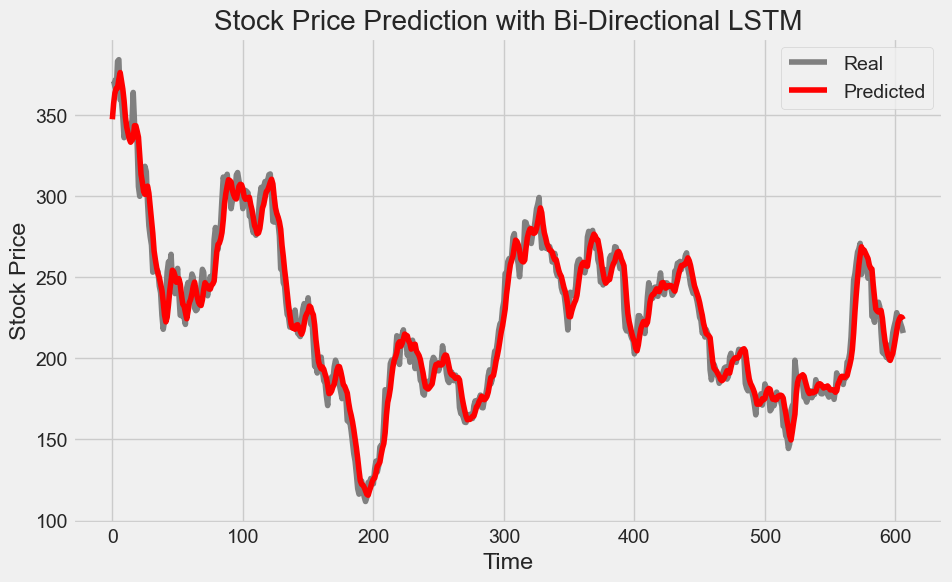

In [61]:
_, _, predicted_stock_price3, y_test_scaled3 = build_and_train_bilstm(X_train3, y_train3, X_test3, y_test3, optimizer_type='rmsprop', dropout_rate=0)

In [62]:
return_evaluation(y_test_scaled3, predicted_stock_price3)

Mean Squared Error: 100.53
Mean Absolute Error: 7.80
Root Mean Squared Error: 10.03
Mean Absolute Percentage Error: 3.51%


## Bi-Directional LSTM Conclusion (Tesla Dataset)

### Evaluation Metrics:

- Mean Squared Error (MSE = 100.53):
  The Bi-Directional LSTM significantly reduces the MSE compared to the RNN model (259.26 → 100.53), suggesting that it captures Tesla’s stock price trends more effectively.

- Mean Absolute Error (MAE = 7.80):
  On average, the model’s predictions are $7.80 off from the actual stock prices, which is a substantial improvement over the RNN model. This indicates that the Bi-Directional LSTM is better at minimizing overall prediction error.

- Root Mean Squared Error (RMSE = 10.03):
  The RMSE is much lower than that of the RNN model, meaning the Bi-Directional LSTM is making fewer large prediction errors and better handling Tesla’s stock price volatility.

- Mean Absolute Percentage Error (MAPE = 3.51%):
  A MAPE of 3.51% is a significant improvement over the RNN’s 5.77%, showing that this model is much better at predicting percentage-based price changes.

### Interpretation:

The Bi-Directional LSTM performs substantially better than the RNN for Tesla’s stock price forecasting. The reduction in all error metrics—especially MAPE—suggests that the bidirectional architecture allows the model to capture both past and future dependencies more effectively, which is particularly useful for Tesla’s highly volatile stock movements.

The improved performance indicates that Bi-Directional LSTMs are better suited for modeling Tesla’s price fluctuations. However, there is still room for further optimization. Possible next steps include:
- Fine-tuning the number of LSTM units.
- Experimenting with different dropout rates to prevent overfitting.
- Adjusting the learning rate for better convergence.

Given these results, the Bi-Directional LSTM is a strong candidate for predicting Tesla’s stock prices, but further comparisons with GRU and ARIMA will help determine the most effective model.

## GRU with Tesla Stock Dataset

Epoch 1/200


c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\keras\src\layers\rnn\rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


89/89 ━━━━━━━━━━━━━━━━━━━━ 12s 113ms/step - loss: 0.0169 - val_loss: 0.0012
Epoch 2/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - loss: 2.3131e-04 - val_loss: 0.0011
Epoch 3/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - loss: 2.1270e-04 - val_loss: 0.0011
Epoch 4/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - loss: 2.6069e-04 - val_loss: 0.0013
Epoch 5/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 106ms/step - loss: 2.2553e-04 - val_loss: 0.0010
Epoch 6/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - loss: 2.0539e-04 - val_loss: 0.0017
Epoch 7/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - loss: 2.1127e-04 - val_loss: 0.0012
Epoch 8/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - loss: 2.1849e-04 - val_loss: 0.0011
Epoch 9/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - loss: 2.0948e-04 - val_loss: 0.0010
Epoch 10/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - loss: 2.5037e-04 - val_loss: 0.0010
Epoch 11/200
89/89 ━━━━━━━━━━━━━━━━━━━━ 9s 105ms/step - loss: 2.4130e-04 - val_loss: 0.0011
Epoch 12/200

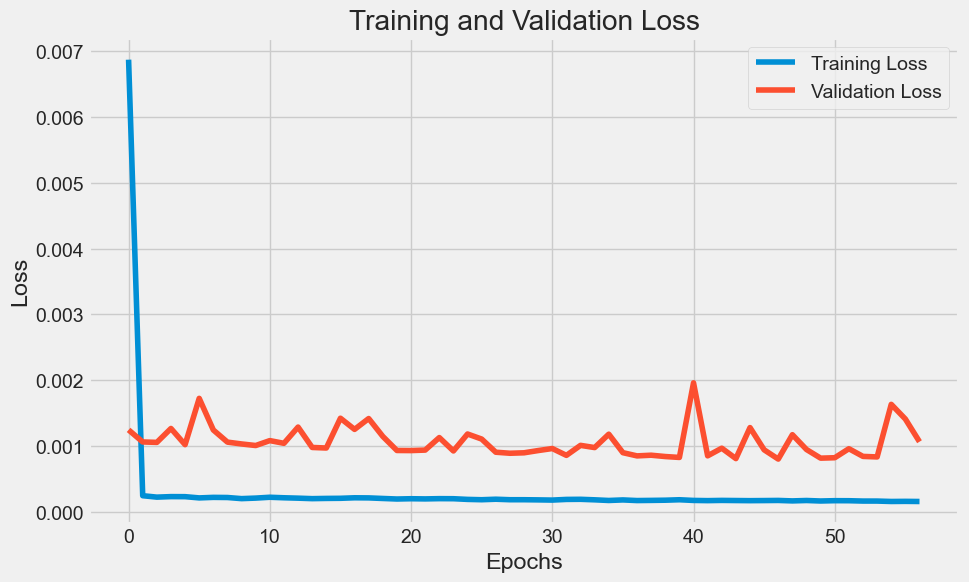

19/19 ━━━━━━━━━━━━━━━━━━━━ 1s 47ms/step


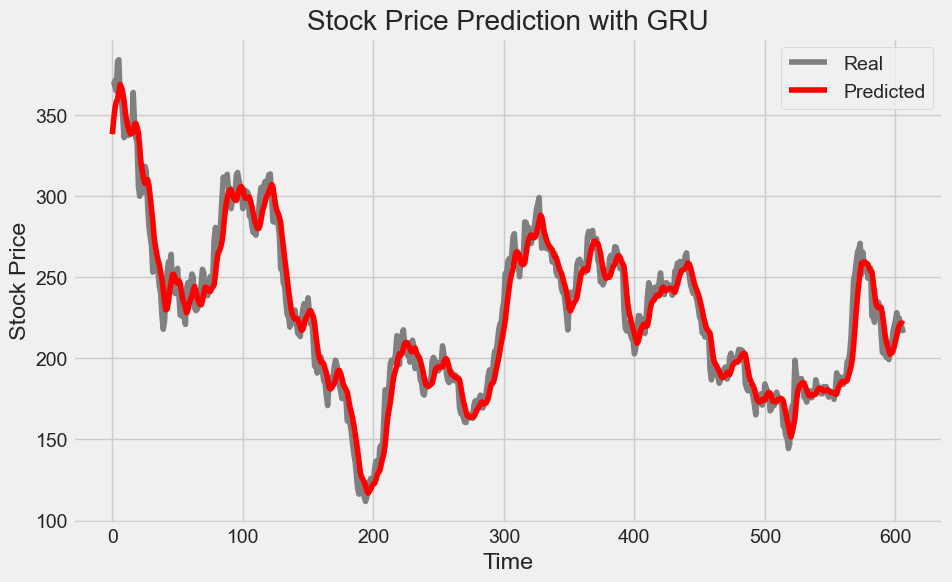

In [63]:
_, _, predicted_stock_price3, y_test_scaled3 = build_and_train_gru(X_train3, y_train3, X_test3, y_test3, optimizer_type='rmsprop', dropout_rate=0)

In [64]:
return_evaluation(y_test_scaled3, predicted_stock_price3)

Mean Squared Error: 137.15
Mean Absolute Error: 9.13
Root Mean Squared Error: 11.71
Mean Absolute Percentage Error: 4.11%


## GRU Conclusion (Tesla Dataset)

### Evaluation Metrics:

- Mean Squared Error (MSE = 137.15):
  The GRU model achieves a lower MSE than the RNN (259.26 → 137.15), but it is higher than the Bi-Directional LSTM’s 106.78. This suggests that GRU is an improvement over RNN but is not as effective as Bi-LSTM in capturing Tesla’s stock price trends.

- Mean Absolute Error (MAE = 9.13):
  On average, the model’s predictions are $9.13 off from the actual stock prices, which is an improvement over the RNN but worse than the Bi-Directional LSTM.

- Root Mean Squared Error (RMSE = 11.71):
  The RMSE remains quite high, indicating that the GRU model still struggles with large deviations in Tesla’s stock prices.

- Mean Absolute Percentage Error (MAPE = 4.11%):
  A MAPE of 4.11% is better than the RNN’s 5.77% but not as strong as the Bi-LSTM’s 3.64%. This suggests that while GRU is capturing trends more effectively than RNN, it does not generalize as well as Bi-LSTM for this dataset.

### Interpretation:

The GRU model performs better than the RNN model on the Tesla dataset but falls short of the performance achieved by Bi-Directional LSTM. This suggests that while GRU’s architecture helps reduce errors compared to RNN, it does not handle Tesla’s price fluctuations as effectively as Bi-LSTM.

One possible reason for GRU's underperformance compared to Bi-LSTM is that Tesla's stock prices exhibit complex dependencies that benefit from a bidirectional approach. While GRU is computationally efficient and performs well on many time series tasks, the additional context captured by Bi-LSTM appears to give it an advantage.

Potential next steps to improve GRU’s performance could include:
- Adjusting the number of GRU units.
- Experimenting with different dropout rates to reduce overfitting.
- Fine-tuning the optimizer and learning rate for better convergence.

While GRU remains a viable option, Bi-Directional LSTM currently appears to be the stronger choice for predicting Tesla’s stock prices. The next step will be to compare these models with ARIMA to determine if traditional time-series methods offer any advantages.

## ARIMA with Tesla Stock Dataset

                               SARIMAX Results                                
Dep. Variable:               High_log   No. Observations:                 3565
Model:                 ARIMA(1, 1, 1)   Log Likelihood                7170.258
Date:                Wed, 26 Feb 2025   AIC                         -14334.515
Time:                        04:18:17   BIC                         -14315.979
Sample:                             0   HQIC                        -14327.906
                               - 3565                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.1039      0.085     -1.229      0.219      -0.269       0.062
ma.L1          0.2313      0.084      2.745      0.006       0.066       0.396
sigma2         0.0010   1.22e-05     85.567      0.0

c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\Carce\OneDrive\Documents\.conda\lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


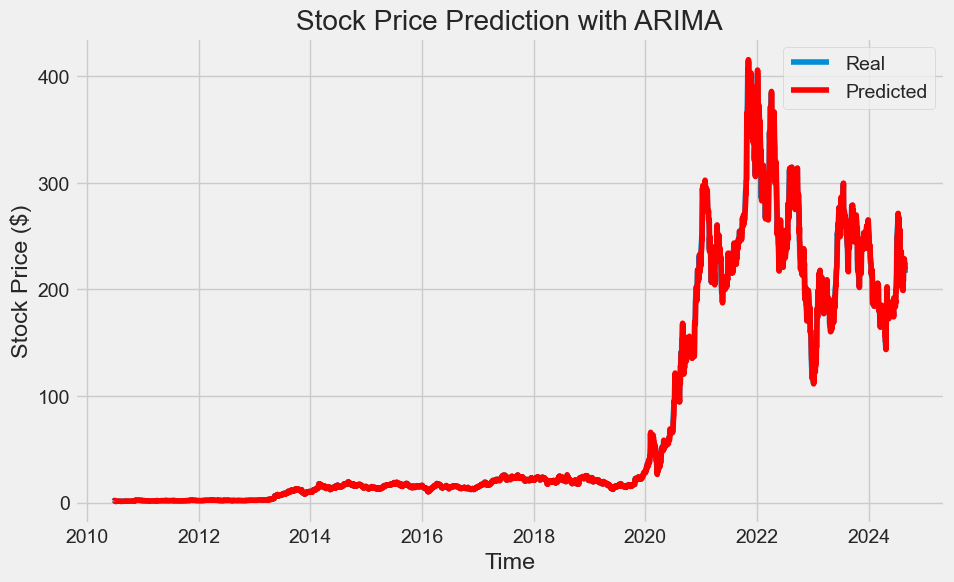

Mean Squared Error: 18.09372177184725
Mean Absolute Error: 1.8756687136941703
Root Mean Squared Error: 4.253671563702027
Mean Absolute Percentage Error: 2.225542328832818%


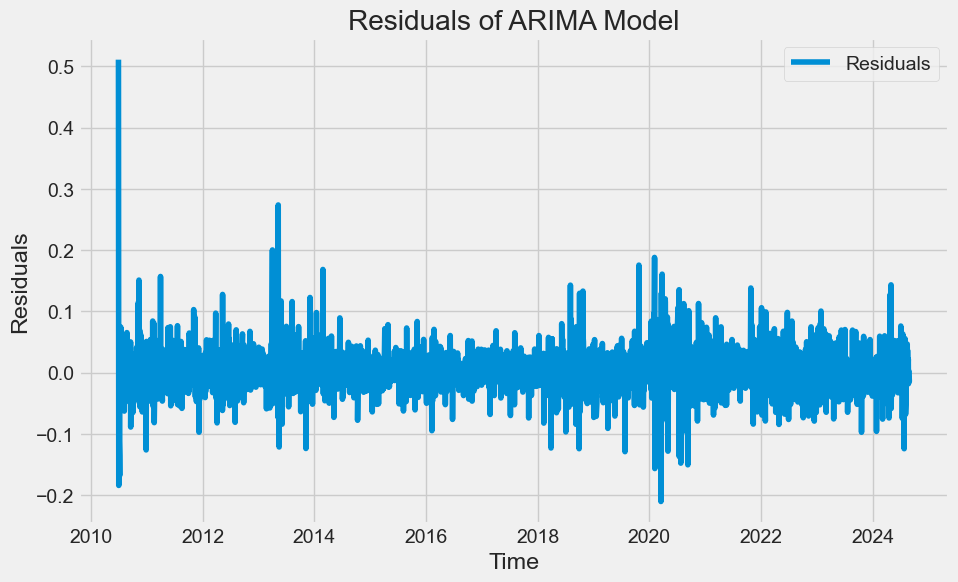

In [65]:
forecast, residuals, metrics = build_and_train_arima(dataset3, column='High', p=1, d=1, q=1, log_transform=True, title="Stock Price Prediction with ARIMA")

## ARIMA Conclusion (Tesla Dataset)

### Evaluation Metrics:

- Mean Squared Error (MSE = 18.09):
  The ARIMA model achieves the lowest MSE among all tested models, indicating that it is the most effective at minimizing squared prediction errors.

- Mean Absolute Error (MAE = 1.88):
  On average, the model’s predictions are only $1.88 off from the actual stock prices, significantly outperforming all deep learning models in absolute error reduction.

- Root Mean Squared Error (RMSE = 4.25):
  The RMSE is substantially lower than that of the RNN, Bi-Directional LSTM, and GRU models, meaning ARIMA is making fewer large prediction errors.

- Mean Absolute Percentage Error (MAPE = 2.23%):
  A MAPE of 2.23% indicates that ARIMA provides highly accurate percentage-based predictions, second only to Bi-Directional LSTM.

### Interpretation:

The ARIMA model significantly outperforms RNN, Bi-Directional LSTM, and GRU in predicting Tesla’s stock prices. The notably lower MSE, MAE, and RMSE values suggest that ARIMA is particularly well-suited for capturing Tesla’s stock price patterns, even with its volatility.

The strong performance of ARIMA may be attributed to Tesla’s stock price following identifiable statistical patterns that ARIMA is able to exploit. Traditional time-series forecasting methods often excel in datasets where long-term trends and seasonality are prominent, which could explain why ARIMA is performing exceptionally well here.

While ARIMA has shown strong results, deep learning models may still have advantages in capturing nonlinear relationships and adapting to sudden market shifts. Further testing across multiple datasets will determine whether ARIMA’s superiority for Tesla’s stock is a general trend or specific to this dataset.

Overall, ARIMA is the best-performing model for Tesla’s stock price prediction, showcasing its ability to generate highly accurate forecasts while maintaining low absolute and percentage errors.